# Skyrmion oscillations by spin currents

## Action plan
1. For this I have to define material parameters to the point where skyrmions are naturally stable.
2. Set the disk geometry of the simulation cell.
3. Set the spin current.
4. Run the simulation.
5. Export an image of the system.
6. FFT the result to find the oscillation frequency.
7. Process the FFT to find peaks.
8. Make a set of values for the spin current, and run the simulation for each spin current.
9. Plot the FFT frequency peak against the current.
10. Determine whether the behavior is linear or not.

## Processing helper functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
import os
import shutil
import re
import subprocess
import glob
from scipy.signal import find_peaks
from numpy import hanning
from numpy import convolve

def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)

    
    return fields

def run_mumax3(script, name, verbose=False, interactive=False):
    """Executes a mumax3 script and converts ovf files to numpy files.
    
    Parameters
    ----------
    script: string containing the mumax3 input script
    name: name of the simulation (this will be the name of the script and output dir)
    verbose: print stdout of mumax3 when it is finished
    interactive: boolean to decide whether to run mumax3 with the user interface
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir = name + ".out"

    # Write the input script in scriptfile
    with open(scriptfile, 'w') as f:
        f.write(script)
    
    # Prepare the command based on the interactive parameter
    command = ["mumax3", "-f"]
    if interactive:
        command.append("-i")
    command.append(scriptfile)
    
    # Call mumax3 to execute the script
    p = run(command, stdout=PIPE, stderr=STDOUT)
    
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    # Assuming functions read_mumax3_table and read_mumax3_ovffiles are defined elsewhere
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
    
    return table

def identify_peaks_and_plot(dm, dt, fmax, ja_value=3.0, min_height=0):
    """
    Identifies the second most significant peak in the FFT of the provided data.

    Parameters:
    - dm: Pandas Series or numpy array of the average magnetization deviation.
    - dt: Sampling time interval.
    - fmax: Maximum frequency to display in the plot.
    - min_height: Minimum height threshold for peak detection.

    Returns:
    - fig: Matplotlib figure object containing the plot.
    - peak_freq: Frequency of the second most significant peak found.
    """
    
    # Apply a Hanning window to the data to reduce spectral leakage
    window = np.hanning(len(dm))
    dm_windowed = dm * window
    
    # Apply a smoothing filter (optional)
    window_len = 11  # Window length for smoothing (must be an odd number)
    dm_smoothed = np.convolve(dm_windowed, np.ones(window_len)/window_len, mode='same')
    
    # Compute the FFT of the windowed and smoothed data
    spectr = np.abs(np.fft.fft(dm_smoothed))  # the absolute value of the FFT of dm
    freq = np.fft.fftfreq(len(dm_smoothed), d=dt)  # the frequencies for this FFT
    
    # Only consider the positive half of the frequencies (ignoring the negative frequencies)
    positive_freqs = freq[:len(freq)//2]
    positive_spectr = spectr[:len(spectr)//2]
    
    # FIND PEAKS - Using 'find_peaks' from scipy.signal
    peaks, properties = find_peaks(positive_spectr, height=min_height)
    
    # Sort peaks by their height
    sorted_peaks = np.argsort(properties['peak_heights'])[::-1]
    
    # Find the first relevant peak
    if len(sorted_peaks) > 1:
        most_significant_peak = peaks[sorted_peaks[0]]
        second_most_significant_peak = peaks[sorted_peaks[1]]
        peak_freq = positive_freqs[most_significant_peak]
    else:
        peak_freq = None  # No relevant peak found
    
    plot_x_render_limit = min(fmax, positive_freqs[-1])

    # CREATE PLOT
    fig, ax = plt.subplots(figsize=(10, 6))  # Optional: Adjust figure size
    ax.plot(positive_freqs/1e9, positive_spectr, label='FFT Spectrum')
    ax.set_xlim(0, plot_x_render_limit/1e9)
    ax.set_ylabel("Spectrum (Arbitrary Units)")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_title(f"Frequency Spectrum of Magnetization Deviation - ja = {ja_value}")
    
    # Highlight and label the second most significant peak
    if peak_freq is not None:
        ax.axvline(x=peak_freq/1e9, color='r', linestyle='--', label=f'First relevant peak at {peak_freq/1e9:.3f} GHz')
    
    # Avoid duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())
    
    ax.grid(True)  # Optional: Adds grid for better readability
    
    # Return the frequency of the second most significant peak
    return fig, peak_freq


def create_incremented_dir(base_dir):
    """
    Checks for existing directories with a number at the end, and creates a new directory
    with the next available number incremented by one from the largest one existent.
    
    Parameters:
    - base_dir: The base name of the directory without the number.
    
    Returns:
    - new_dir_path: The path to the newly created directory.
    - dir_number: The number assigned to the new directory.
    """
    # Regular expression to match the pattern of the directories
    dir_pattern = re.compile(r'^' + re.escape(base_dir) + r'(\d+)$')
    
    # Get all items in the current directory
    items = os.listdir()
    
    # Filter items that match the pattern and extract numbers
    numbers = [int(match.group(1)) for item in items if (match := dir_pattern.match(item))]
    
    # Determine the next directory number
    dir_number = max(numbers) + 1 if numbers else 1
    
    # Form the new directory path
    new_dir_path = f"{base_dir}{dir_number}"
    
    # Create the new directory
    os.makedirs(new_dir_path, exist_ok=True)
    
    return new_dir_path, dir_number

def get_latest_incremented_dir(base_dir):
    """
    Checks for existing directories with a number at the end and returns the path 
    to the directory with the highest number.

    Parameters:
    - base_dir: The base name of the directory without the number.

    Returns:
    - latest_dir_path: The path to the latest directory with the highest number.
    - dir_number: The highest number found.
    """
    # Regular expression to match the pattern of the directories
    dir_pattern = re.compile(r'^' + re.escape(base_dir) + r'(\d+)$')
    
    # Get all items in the current directory
    items = os.listdir()
    
    # Filter items that match the pattern and extract numbers
    numbers = [int(match.group(1)) for item in items if (match := dir_pattern.match(item))]
    
    if numbers:
        # Find the highest directory number
        dir_number = max(numbers)
        
        # Form the latest directory path
        latest_dir_path = f"{base_dir}{dir_number}"
    else:
        latest_dir_path = None
        dir_number = None
    
    return latest_dir_path, dir_number

def convert_ovf_to_jpg(input_dir, output_dir):
    # Find all .ovf files in the input directory
    ovf_files = glob.glob(os.path.join(input_dir, '*.ovf'))
    
    # Iterate over each .ovf file and execute the conversion command
    for ovf_file in ovf_files:
        # Define the output filename with .jpg extension
        output_filename = os.path.basename(ovf_file).replace('.ovf', '.jpg')
        
        # Execute the mumax3-convert command
        subprocess.run(['mumax3-convert', '-jpg', '-o', output_dir, ovf_file])

def delete_path(path_to_delete, extension=None):
    if os.path.isfile(path_to_delete):
        os.remove(path_to_delete)  # Removes a file.
    elif os.path.isdir(path_to_delete) and extension is None:
        shutil.rmtree(path_to_delete)  # Removes a directory and all its contents.
    elif os.path.isdir(path_to_delete) and extension is not None:
        # Delete all files with the specified extension in the directory
        files_to_delete = glob.glob(os.path.join(path_to_delete, f'*{extension}'))
        for file in files_to_delete:
            os.remove(file)
    else:
        print(f"The path {path_to_delete} is invalid or does not exist.")

def extract_ja_values_by_folder_scheme(iteration_dir):
    """
    Reads the names of folders in the specified directory with the naming scheme
    'oscillating_Skyrmion_ja=<value>.out' and extracts the values in scientific notation.

    Parameters:
    - iteration_dir: The directory in which to look for the folders.

    Returns:
    - ja_values: A list of values extracted from the folder names.
    """
    ja_values = []
    pattern = re.compile(r'oscillating_Skyrmion_ja=([0-9.]+e[+-]?[0-9]+)\.out')
    
    for item in os.listdir(iteration_dir):
        match = pattern.match(item)
        if match:
            ja_value = float(match.group(1))  # Convert the scientific notation string to a float
            ja_values.append(ja_value)
    
    ja_values = np.array(ja_values)
    ja_values.sort()
    return ja_values

## Mumax3 Script generator

In [5]:
default_fmax = 200e9
default_dt = 1/(2*default_fmax)
default_T = 2e-9
default_Dind = 3e-3
default_Ku1 = 0.8e+6
default_sq_charge = 1
def generate_skyrmion_breathing_script(
        fmax = default_fmax,
        t = default_T,
        ja = 3e12,
        dind = default_Dind,
        ku1 = default_Ku1,
        sq_charge = default_sq_charge):

    # NUMERICAL PARAMETERS RELEVANT FOR THE SPECTRUM ANALYSIS
    fmax # maximum frequency (in Hz) of the sinc pulse
    t    # simulation time (longer -> better frequency resolution)
    dt   = 1/(2*fmax)  # the sample time (Nyquist theorem taken into account)
    ja   # the spin current - A/m2
    default_fmax = fmax
    default_dt = dt
    default_T = t

    script=f"""
    // geometry
    sizeX := 200e-9
    sizeY := 200e-9
    sizeZ :=1e-9

    // inner circle for injecting current

    sizeX2 := 50e-9
    sizey2 := 50e-9

    Nx := 192
    Ny := 192
    Nz := 1
    
    setgridsize(Nx, Ny, Nz)
    setcellsize(sizeX/Nx, sizeY/Ny, sizeZ/Nz)
    setGeom(ellipse(sizeX, sizeY))

    defRegion(1,circle(sizeX2))


    // set up free layer
    Msat = 580e+3    // A/m
    Aex= 1.5e-11     // exchange stiffness Fe
    alpha = 0.3

    //m = uniform(0, 0, 1)

    Dind_ini :={dind}   // J/m2   calculated ab-initio Au/Fe/MgO
    Ku1_ini := {ku1} // J/m3   calculated ab-initio Au/Fe/MgO

    Dind = Dind_ini
    Ku1 =Ku1_ini
    AnisU = vector(0,0,1)

    m = NeelSkyrmion({sq_charge},-1).scale(3,3,1)

    minimize()

    V:=0.0
    Dind_red:=Dind_ini*(1-V)
    Ku1_red:= Ku1_ini*(1-V)
    AnisU = vector(0,0,1)

    // set up fixed and spacer layer parameters
    lambda = 1
    Pol= 0.8
    epsilonprime = 0
    xi=0.2

    // set up fixed layer polarization

    fixedlayer = vector(0, 0, 1)


    //Temp=300.00

    ja:={-ja}			// A/m2
    J.setRegion(1,vector(0,0,-ja)) 	// A/m2

    Dind = Dind_ini
    Ku1 = Ku1_ini

    Dind.setRegion(1, Dind_red)
    Ku1.setRegion(1, Ku1_red)

    Ba:=0.1
    B_ext=vector(0.0,0.0,Ba)

    tableadd(E_total)
    tableadd(maxangle)
    autosave(m, {dt})
    tableautosave({dt})
    run({t})
    """

    return script

## Run the script below to process the end-to-end study

In [6]:
iteration_dir = 'run_files'

iteration_dir, dir_number = create_incremented_dir(iteration_dir)
min_fft_peak_height = 20
should_delete_ovf_files = False

# Writing to files
ja_values = np.arange(0, 4.8e12, 0.25e12)
#ja_values = np.array([3e12])
for i, ja in enumerate(ja_values):
    output_dir = f"{iteration_dir}{os.path.sep}oscillating_Skyrmion_ja={ja/1e12}e12"
    table = run_mumax3(
        generate_skyrmion_breathing_script(
            ja=ja,
            dind=3e-3,
            ku1=0.8e+6,
            sq_charge=1,
            t=3e-9),
        name=output_dir,
        verbose=False,
        interactive=False)
    
    # Save table and fields to disk
    npy_dir = f"{iteration_dir}{os.path.sep}npy_arrays"
    os.makedirs(npy_dir, exist_ok=True)
    np.save(os.path.join(npy_dir, f"table_{i}.npy"), table)

    # Save images for each run
    images_dir = f"{output_dir}.out{os.path.sep}images"
    os.makedirs(images_dir, exist_ok=True)
    convert_ovf_to_jpg(f"{output_dir}.out", images_dir)

    # Convert images to video and delete originals
    subprocess.run([
    'ffmpeg', '-r', '30', '-pattern_type', 'glob', 
    '-analyzeduration', '100000000', '-probesize', '100000000',  # Added analyzeduration and probesize
    '-i', f'{images_dir}{os.path.sep}*.jpg',
    '-c:v', 'libvpx-vp9', '-pix_fmt', 'yuv420p', '-crf', '30', '-b:v', '0',
    '-preset', 'veryfast', f'{iteration_dir}{os.path.sep}ja={ja/1e12}e12.webm'
    ])
    delete_path(images_dir)

    # Delete large files if requested
    if should_delete_ovf_files:
        delete_path(f"{output_dir}.out", extension='.ovf')

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000005.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000019.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000033.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000041.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000044.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000052.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000055.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000065.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000068.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000076.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000057.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000277.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000091.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000089.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000107.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000124.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000122.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000139.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000136.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000152.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000150.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000167.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000165.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000183.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000181.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000196.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000194.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000213.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000204.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000204.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000211.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000224.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000235.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000235.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000246.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000244.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000256.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000254.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000268.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000266.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000280.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000294.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000293.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000306.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000305.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000319.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000319.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000333.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000332.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000348.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000366.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000366.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000380.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000391.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000390.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000407.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000408.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000430.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000425.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000425.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000431.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000450.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000450.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000467.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000468.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000486.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000487.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000503.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000503.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000519.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000535.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000551.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000553.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000567.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000567.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000568.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000580.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000592.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000602.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000604.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000616.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000620.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000630.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000631.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000641.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000642.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000652.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000653.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000663.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000664.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000674.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000676.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000685.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000685.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000688.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000701.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000712.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000715.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000725.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000728.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000377.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000437.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000437.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000557.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000677.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000677.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000743.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000751.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000756.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000764.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000770.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000778.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000784.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000791.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000798.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000807.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000814.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000831.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000839.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000843.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000843.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000844.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000844.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000847.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000854.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000856.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000856.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000863.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000870.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000876.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000883.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000890.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000898.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000903.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000916.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000924.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000931.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000931.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000932.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000939.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000945.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000950.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000955.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000961.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000966.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000972.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000979.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000992.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000999.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001006.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001012.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001021.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001026.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001033.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001039.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001047.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001052.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001061.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001067.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001079.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001095.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000937.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001017.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001177.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001119.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001124.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001142.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001146.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001160.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001178.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=0.0e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001196.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.0e12.out/m001199.ovf
1 files co

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000020.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000010.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000032.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000054.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000066.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000076.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000257.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000087.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000103.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000115.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000126.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000143.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000163.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000181.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000210.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000226.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000242.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000256.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000273.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000301.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000311.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000322.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000322.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000322.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000334.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000348.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000360.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000370.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000382.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000393.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000405.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000431.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000444.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000454.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000465.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000475.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000488.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000513.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000525.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000556.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000570.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000584.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000596.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000609.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000625.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000638.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000651.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000666.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000678.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000688.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000699.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000711.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000726.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000397.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000437.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000437.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000637.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000637.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000657.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000657.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000677.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000677.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000743.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000746.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000746.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000756.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000813.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000846.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000888.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000906.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000925.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000931.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000931.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000940.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000955.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000971.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001024.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001024.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001034.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001049.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001061.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001071.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001082.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001092.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000837.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001037.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001113.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001136.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001132.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001145.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001155.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001168.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001181.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=0.25e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.25e12.out/m

run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.25e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000007.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000018.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000008.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000009.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000010.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000015.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000030.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000028.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000041.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000040.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000048.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000043.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000048.jpg


1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000056.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000053.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000056.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000067.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000065.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000076.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000068.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000075.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000197.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000157.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000081.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000079.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000090.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000089.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000101.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000100.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000113.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000112.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000123.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000132.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000141.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000141.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000151.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000149.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000162.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000160.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000172.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000170.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000184.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000182.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000195.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000193.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000203.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000203.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000204.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000204.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000207.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000215.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000215.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000223.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000239.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000238.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000252.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000251.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000267.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000265.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000281.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000279.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000294.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000292.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000308.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000306.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000320.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000336.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000335.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000349.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000364.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000364.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000374.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000374.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000386.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000386.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000398.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000398.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000409.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000422.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000424.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000435.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000436.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000447.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000449.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000460.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000460.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000464.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000475.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000480.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000494.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000507.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000510.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000520.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000522.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000536.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000550.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000558.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000573.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000579.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000591.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000595.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000605.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000612.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000624.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000631.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000640.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000645.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000654.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000660.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000678.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000687.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000694.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000702.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000707.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000715.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000720.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000731.jpg


run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000734.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000417.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000517.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000637.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000746.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000751.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000756.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000767.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000780.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000784.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000784.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000784.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000785.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000785.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000787.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000787.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000790.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000794.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000803.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000807.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000816.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000820.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000828.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000831.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000842.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000845.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000852.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000854.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000854.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000854.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000856.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000856.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000862.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000865.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000873.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000876.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000887.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000890.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000893.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000893.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000894.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000894.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000900.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000903.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000905.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000905.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000907.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000907.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000911.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000914.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000925.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000928.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000943.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000960.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000958.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000974.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000970.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000970.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000972.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000988.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000987.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001002.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001001.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001015.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001028.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001024.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001028.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001040.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001041.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001055.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001055.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001067.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001066.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001078.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001076.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001088.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001087.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000777.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001017.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001037.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001102.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001104.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001115.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001116.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001128.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001128.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001140.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001142.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001154.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001158.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001171.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001174.ovf	-> r

run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001191.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.5e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=0.5e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libg

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000023.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000036.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000030.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000050.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000043.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000062.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000053.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000075.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000067.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000068.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000217.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000082.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000109.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000120.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000129.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000140.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000152.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000163.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000174.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000186.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000199.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000209.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000245.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000260.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000278.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000288.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000299.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000319.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000342.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000375.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000393.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000410.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000412.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000412.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000413.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000413.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000425.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000440.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000471.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000486.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000496.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000508.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000510.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000510.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000532.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000538.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000538.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000542.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000552.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000563.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000567.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000567.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000573.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000584.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000595.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000606.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000620.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000632.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000643.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000678.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000691.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000685.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000685.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000702.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000577.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000437.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000437.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000744.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000756.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000769.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000783.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000796.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000824.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000836.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000847.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000843.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000843.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000844.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000844.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000855.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000854.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000854.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000866.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000891.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000938.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000951.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000966.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000970.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000970.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000982.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000993.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001004.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001044.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001094.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001101.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001116.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001132.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001160.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001193.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=0.75e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=0.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=0.75e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000019.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000009.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000010.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000016.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000031.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000029.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000043.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000042.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000053.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000052.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000065.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000063.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000075.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000067.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000068.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000073.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000197.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000177.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000083.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000082.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000098.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000096.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000111.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000125.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000124.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000134.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000134.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000145.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000145.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000163.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000164.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000181.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000182.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000199.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000199.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000213.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000214.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000229.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000230.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000245.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000246.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000261.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000275.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000276.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000291.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000303.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000304.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000316.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000315.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000326.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000322.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000322.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000327.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000336.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000335.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000348.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000348.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000360.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000368.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000379.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000390.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000399.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000410.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000411.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000423.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000423.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000434.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000447.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000449.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000459.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000460.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000467.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000469.jpg


1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000478.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000471.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000471.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000478.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000488.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000489.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000502.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000503.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000513.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000510.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000510.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000514.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000527.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000522.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000522.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000524.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000524.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000525.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000525.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000527.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000540.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000538.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000538.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000540.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000551.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000553.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000567.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000567.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000569.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000583.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000595.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000607.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000609.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000620.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000622.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000630.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000635.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000645.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000648.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000658.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000664.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000673.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000679.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000687.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000685.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000685.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000691.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000702.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000710.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000713.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000722.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000726.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000733.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000397.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000537.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000597.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000677.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000677.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000743.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000754.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000761.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000767.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000774.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000781.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000788.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000796.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000803.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000812.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000825.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000835.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000843.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000843.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000844.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000844.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000848.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000854.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000870.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000888.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000893.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000904.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000909.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000920.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000926.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000931.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000931.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000935.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000942.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000949.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000955.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000966.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000972.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000981.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000988.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000999.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001005.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001015.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001021.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001024.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001029.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001034.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001041.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001045.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001051.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001055.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001064.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001073.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001084.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001088.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001094.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000757.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000917.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000957.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001077.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001157.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001105.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001116.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001120.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001129.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001143.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001151.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001153.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001161.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001164.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001172.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001175.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001185.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001197.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=1.0e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001195.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.0e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000020.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000010.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000032.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000044.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000054.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000067.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000077.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000297.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000101.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000112.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000139.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000150.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000161.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000185.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000196.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000210.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000223.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000234.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000247.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000261.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000300.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000312.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000326.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000348.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000367.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000385.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000433.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000448.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000479.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000491.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000505.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000516.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000522.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000522.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000530.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000544.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000556.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000569.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000594.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000607.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000633.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000658.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000670.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000682.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000685.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000685.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000693.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000704.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000718.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000752.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000776.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000789.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000832.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000846.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000859.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000871.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000896.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000950.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000963.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000975.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001000.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001015.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001028.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001041.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001081.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000777.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001057.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001107.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001124.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001132.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001139.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001169.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001196.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enabl

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.25e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


Input #0, image2, from 'run_files4/oscillating_Skyrmion_ja=1.25e12.out/images/*.jpg':
  Duration: 00:00:48.04, start: 0.000000, bitrate: N/A
  Stream #0:0: Video: mjpeg (Baseline), yuvj420p(pc, bt470bg/unknown/unknown), 192x192, 25 fps, 25 tbr, 25 tbn, 25 tbc
Codec AVOption preset (Configuration preset) specified for output file #0 (run_files4/ja=1.25e12.webm) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> vp9 (libvpx-vp9))
Press [q] to stop, [?] for help
[swscaler @ 0x5fd96f7f3840] deprecated pixel format used, make sure you did set range correctly
[libvpx-vp9 @ 0x5fd96ec9cf40] v1.11.0
Output #0, webm, to 'run_files4/ja=1.25e12.webm':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: vp9, yuv420p(tv, bt470bg/unknown/unknown, progressive), 192x192

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000005.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000028.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000051.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000064.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000067.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000057.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000117.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000079.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000096.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000094.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000111.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000109.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000126.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000124.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000142.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000141.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000158.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000170.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000169.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000182.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000194.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000193.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000206.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000203.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000203.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000204.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000204.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000205.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000216.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000214.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000214.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000215.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000229.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000228.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000241.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000241.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000251.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000251.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000262.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000274.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000273.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000285.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000298.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000294.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000294.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000298.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000309.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000310.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000320.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000322.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000333.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000343.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000344.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000353.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000355.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000365.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000366.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000375.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000378.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000387.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000390.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000401.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000411.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000411.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000412.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000412.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000413.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000425.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000425.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000428.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000438.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000442.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000451.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000455.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000464.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000460.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000460.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000467.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000478.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000481.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000491.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000494.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000503.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000506.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000516.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000520.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000529.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000533.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000543.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000547.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000555.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000559.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000569.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000567.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000567.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000572.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000580.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000583.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000591.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000595.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000604.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000608.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000615.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000619.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000627.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000631.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000640.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000644.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000650.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000655.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000662.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000670.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000676.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000681.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000687.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000695.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000703.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000709.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000716.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000721.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000728.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000734.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000437.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000617.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000742.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000746.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000746.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000753.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000762.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000771.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000779.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000784.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000784.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000785.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000785.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000787.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000803.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000811.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000821.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000828.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000838.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000844.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000844.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000844.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000851.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000859.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000867.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000875.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000882.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000888.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000893.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000893.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000894.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000894.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000895.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000902.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000905.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000905.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000907.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000913.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000919.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000931.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000938.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000943.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000949.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000955.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000962.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000968.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000974.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000979.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000985.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000992.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001010.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001015.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001021.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001024.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001029.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001033.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001042.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001053.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001058.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001066.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001070.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001076.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001081.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001089.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000797.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000877.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001057.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001103.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001106.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001115.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001119.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001132.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001135.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001147.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001150.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001162.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001165.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001173.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001189.ovf	-> r

run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.5e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=1.5e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFm

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000019.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000010.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000029.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000042.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000053.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000076.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000217.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000107.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000118.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000129.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000153.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000201.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000212.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000239.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000250.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000275.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000294.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000294.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000309.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000321.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000331.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000344.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000358.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000369.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000396.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000409.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000411.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000411.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000433.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000446.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000461.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000481.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000511.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000529.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000546.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000561.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000575.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000590.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000605.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000619.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000632.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000656.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000668.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000691.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000703.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000716.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000729.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000477.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000738.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000749.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000762.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000786.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000784.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000784.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000785.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000785.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000787.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000787.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000796.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000807.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000819.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000843.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000843.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000844.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000844.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000855.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000869.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000883.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000907.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000945.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000971.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000998.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001008.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001021.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001032.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001046.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001060.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001071.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001083.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001095.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001100.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001128.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001141.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001159.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001179.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001197.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=1.75e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=1.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000023.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000021.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000035.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000030.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000034.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000046.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000043.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000044.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000059.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000053.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000058.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000070.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000067.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000068.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000069.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000137.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000157.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000085.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000086.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000102.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000118.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000118.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000131.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000146.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000148.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000163.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000164.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000178.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000190.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000191.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000205.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000203.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000203.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000204.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000204.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000207.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000221.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000215.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000215.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000223.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000234.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000235.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000246.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000246.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000258.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000259.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000269.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000269.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000280.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000281.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000291.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000292.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000303.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000304.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000314.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000315.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000327.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000322.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000322.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000328.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000341.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000352.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000362.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000364.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000374.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000375.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000387.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000398.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000407.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000410.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000419.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000422.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000430.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000425.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000425.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000432.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000441.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000444.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000452.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000456.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000464.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000469.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000484.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000498.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000509.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000516.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000522.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000522.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000524.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000532.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000538.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000544.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000549.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000555.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000565.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000571.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000576.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000583.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000589.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000602.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000607.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000612.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000624.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000629.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000634.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000640.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000647.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000652.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000661.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000665.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000671.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000675.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000683.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000694.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000698.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000707.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000710.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000720.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000723.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000377.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000437.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000637.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000697.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000746.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000749.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000759.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000762.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000780.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000783.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000801.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000804.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000818.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000821.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000835.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000854.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000852.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000868.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000884.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000899.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000893.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000893.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000894.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000894.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000899.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000913.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000907.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000907.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000913.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000927.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000927.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000940.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000940.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000952.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000952.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000961.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000958.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000958.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000963.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000971.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000970.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000970.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000972.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000985.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000996.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000996.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001007.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001007.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001020.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001020.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001032.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001032.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001044.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001043.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001055.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001054.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001066.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001066.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001078.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001079.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001089.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001091.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000777.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000817.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000977.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001017.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001177.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001098.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001110.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001120.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001125.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001134.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001132.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001139.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001153.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001166.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001173.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001179.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001186.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001192.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001199.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.0e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=2.0e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000023.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000036.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000030.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000047.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000043.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000059.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000053.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000069.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000257.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000083.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000107.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000118.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000130.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000141.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000151.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000163.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000175.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000187.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000199.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000210.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000204.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000204.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000223.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000234.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000247.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000258.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000299.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000314.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000348.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000361.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000378.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000390.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000406.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000446.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000456.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000470.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000471.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000471.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000481.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000492.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000505.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000516.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000530.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000525.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000525.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000538.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000538.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000552.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000564.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000587.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000599.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000676.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000704.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000720.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000731.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000637.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000637.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000740.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000751.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000764.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000776.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000788.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000787.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000787.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000800.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000811.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000824.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000835.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000849.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000854.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000854.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000862.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000876.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000893.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000893.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000899.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000905.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000905.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000910.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000922.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000934.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000949.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000958.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000958.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000975.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000987.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001025.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001047.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001063.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001080.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001095.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000977.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001102.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001145.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001156.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001170.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001185.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001196.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.25e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=2.25e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libo

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000028.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000041.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000044.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000053.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000056.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000066.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000069.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000057.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000078.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000317.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000087.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000101.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000100.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000112.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000111.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000125.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000124.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000138.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000135.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000148.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000146.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000159.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000156.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000171.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000169.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000182.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000180.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000192.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000203.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000203.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000204.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000204.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000206.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000214.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000214.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000215.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000215.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000219.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000231.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000232.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000243.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000245.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000256.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000260.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000273.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000286.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000294.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000294.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000300.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000308.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000313.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000334.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000345.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000350.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000361.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000366.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000376.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000381.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000392.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000396.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000405.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000409.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000425.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000435.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000440.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000454.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000462.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000468.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000475.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000481.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000488.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000493.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000501.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000505.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000512.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000519.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000525.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000524.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000524.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000525.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000525.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000530.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000536.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000538.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000538.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000544.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000549.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000553.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000560.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000566.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000572.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000579.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000590.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000595.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000604.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000609.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000614.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000620.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000626.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000631.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000636.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000642.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000647.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000652.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000659.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000663.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000670.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000673.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000683.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000686.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000695.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000699.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000712.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000728.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000726.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000437.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000397.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000637.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000617.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000744.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000744.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000755.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000768.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000769.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000781.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000783.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000793.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000795.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000806.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000808.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000816.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000819.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000831.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000841.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000849.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000853.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000862.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000856.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000856.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000863.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000875.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000889.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000899.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000903.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000911.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000915.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000923.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000927.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000935.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000940.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000947.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000951.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000960.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000958.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000958.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000965.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000970.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000970.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000978.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000985.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000991.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001003.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001009.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001018.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001027.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001038.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001045.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001053.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001060.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001069.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001076.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001085.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001092.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000757.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000917.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001037.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001177.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001103.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001110.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001119.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001132.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001133.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001139.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001146.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001151.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001158.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001171.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001183.ovf	-> r

run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=2.5e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001196.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.5e12.out/m001200.ovf
1 files co

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000020.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000010.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000030.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000043.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000053.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000067.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000068.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000157.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000078.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000088.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000099.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000109.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000143.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000154.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000166.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000176.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000187.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000222.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000234.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000248.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000270.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000281.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000293.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000294.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000294.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000305.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000315.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000328.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000339.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000350.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000361.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000375.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000388.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000403.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000416.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000429.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000460.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000481.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000498.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000522.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000522.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000544.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000571.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000587.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000599.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000611.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000623.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000635.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000647.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000673.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000685.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000710.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000722.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000733.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000517.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000637.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000637.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000740.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000746.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000746.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000764.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000799.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000812.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000827.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000840.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000855.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000856.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000856.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000867.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000880.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000893.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000906.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000944.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000958.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000983.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000994.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001016.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001024.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001053.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001065.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001078.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000877.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001106.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001116.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001127.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001144.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001163.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001181.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001197.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=2.75e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=2.75e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 200

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000024.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000022.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000030.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000036.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000050.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000043.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000048.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000065.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000063.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000037.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000076.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000217.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000083.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000094.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000094.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000105.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000103.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000115.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000113.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000126.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000136.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000149.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000148.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000161.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000160.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000172.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000171.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000183.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000182.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000192.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000193.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000203.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000203.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000215.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000214.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000214.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000215.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000226.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000226.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000238.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000238.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000249.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000250.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000261.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000263.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000271.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000272.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000284.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000285.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000295.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000294.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000294.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000296.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000306.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000307.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000318.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000319.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000328.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000330.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000343.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000352.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000356.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000368.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000378.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000381.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000390.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000392.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000402.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000405.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000411.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000411.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000412.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000412.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000413.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000413.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000416.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000427.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000425.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000425.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000430.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000441.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000452.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000462.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000460.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000460.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000464.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000474.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000471.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000471.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000476.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000484.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000487.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000494.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000496.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000505.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000507.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000519.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000524.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000524.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000525.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000525.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000530.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000539.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000538.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000538.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000542.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000549.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000552.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000560.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000563.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000572.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000575.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000583.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000586.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000593.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000598.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000606.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000610.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000620.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000625.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000638.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000646.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000651.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000672.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000682.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000685.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000685.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000689.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000699.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000703.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000719.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000728.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000735.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000477.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000597.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000740.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000744.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000753.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000761.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000771.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000771.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000774.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000783.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000784.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000784.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000785.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000785.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000787.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000794.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000799.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000807.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000810.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000819.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000823.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000829.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000833.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000841.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000843.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000843.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000844.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000844.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000847.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000854.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000854.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000854.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000856.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000856.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000859.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000870.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000878.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000882.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000888.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000892.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000903.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000910.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000907.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000907.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000913.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000921.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000926.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000933.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000931.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000931.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000936.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000949.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000958.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000958.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000960.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000970.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000970.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000972.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000979.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000983.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000987.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000992.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000998.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001004.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001008.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001014.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001024.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001035.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001039.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001048.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001051.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001061.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001064.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001073.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001087.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001085.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000737.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001017.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000977.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001101.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001099.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001111.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001111.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001122.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001120.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001132.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001143.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001143.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001152.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001153.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001161.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001162.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001171.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001179.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001181.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001186.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001189.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001196.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001198.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000024.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000038.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000030.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000052.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000043.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000053.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000074.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000067.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000068.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000083.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000094.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000107.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000119.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000169.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000180.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000190.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000201.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000210.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000221.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000215.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000215.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000231.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000252.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000263.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000272.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000283.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000294.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000294.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000305.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000327.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000340.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000352.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000366.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000401.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000412.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000411.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000411.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000412.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000412.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000413.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000413.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000425.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000425.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000460.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000460.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000471.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000471.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000471.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000493.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000505.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000510.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000510.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000515.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000526.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000538.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000538.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000538.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000548.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000580.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000590.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000602.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000612.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000623.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000636.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000648.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000659.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000669.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000703.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000719.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000731.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000637.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000637.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000657.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000657.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000677.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000677.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000743.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000746.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000746.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000754.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000771.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000771.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000796.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000810.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000823.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000835.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000846.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000854.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000854.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000860.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000873.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000888.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000893.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000893.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000894.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000894.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000899.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000905.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000905.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000910.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000922.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000933.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000960.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000971.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000982.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000993.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001005.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001009.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001009.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001015.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001027.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001039.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001053.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001067.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001092.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000837.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001057.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001101.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001113.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001125.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001135.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001132.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001146.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001179.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001188.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001198.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=3.25e12.out/images/m001200.jpg


1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.25e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000024.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000023.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000040.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000039.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000053.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000068.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000066.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000037.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000076.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000277.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000257.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000087.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000086.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000096.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000109.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000108.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000122.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000121.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000135.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000134.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000149.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000148.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000159.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000170.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000179.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000189.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000201.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000201.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000211.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000212.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000222.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000224.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000232.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000232.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000243.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000244.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000254.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000265.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000274.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000271.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000271.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000276.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000285.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000288.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000298.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000294.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000294.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000299.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000308.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000312.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000322.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000333.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000341.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000345.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000356.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000363.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000367.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000373.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000378.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000384.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000389.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000393.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000398.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000404.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000410.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000416.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000424.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000431.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000436.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000445.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000449.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000458.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000460.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000471.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000485.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000491.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000495.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000502.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000508.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000514.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000520.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000533.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000541.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000547.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000551.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000556.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000562.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000567.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000576.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000580.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000587.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000590.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000599.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000602.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000611.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000614.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000622.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000625.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000635.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000639.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000647.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000650.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000659.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000662.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000672.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000687.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000685.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000704.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000702.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000715.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000724.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000724.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000734.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000732.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000617.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000597.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000752.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000746.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000746.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000751.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000766.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000765.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000780.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000771.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000771.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000779.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000798.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000810.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000810.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000824.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000838.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000838.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000843.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000843.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000844.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000844.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000850.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000856.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000856.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000863.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000873.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000886.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000886.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000898.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000893.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000893.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000894.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000894.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000898.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000909.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000905.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000905.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000907.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000907.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000909.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000923.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000931.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000931.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000936.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000946.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000947.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000958.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000968.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000976.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000979.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000987.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000989.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000996.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000996.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000998.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000998.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001000.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001009.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001016.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001019.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001027.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001024.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001029.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001040.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001046.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001049.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001056.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001060.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001067.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001071.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001075.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001081.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001086.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001091.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001096.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000817.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000917.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001037.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001137.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001105.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001110.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001118.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001123.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001129.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001133.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001141.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001143.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001150.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001153.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001165.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001180.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001178.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001192.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001190.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=3.5e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.5e12.out/m001200.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000027.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000030.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000054.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000077.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000337.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000089.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000112.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000123.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000134.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000147.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000182.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000192.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000203.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000213.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000223.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000215.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000215.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000254.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000266.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000291.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000304.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000314.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000325.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000322.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000322.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000334.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000345.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000379.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000391.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000405.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000419.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000413.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000413.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000431.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000445.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000456.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000468.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000492.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000505.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000519.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000522.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000522.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000532.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000545.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000567.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000567.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000610.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000633.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000659.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000669.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000673.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000673.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000684.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000685.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000685.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000686.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000686.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000696.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000696.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000709.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000722.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000735.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000437.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000437.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000577.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000769.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000771.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000771.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000781.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000784.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000784.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000785.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000785.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000787.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000787.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000794.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000821.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000833.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000854.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000854.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000855.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000855.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000874.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000882.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000882.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000888.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000893.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000893.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000894.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000894.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000905.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000905.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000907.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000907.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000923.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000933.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000946.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000956.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000958.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000958.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000970.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000970.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001009.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001008.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001008.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001022.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001033.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001045.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001089.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000777.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001131.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001153.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001176.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001187.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001198.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.75e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.75e12.out/m

run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.75e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000019.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000019.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000029.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000020.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000021.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000027.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000042.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000041.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000054.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000053.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000065.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000065.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000076.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000076.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000237.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000237.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000082.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000082.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000094.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000105.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000106.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000116.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000118.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000128.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000129.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000140.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000141.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000152.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000154.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000166.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000167.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000181.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000193.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000198.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000213.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000226.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000234.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000239.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000249.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000254.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000263.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000260.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000260.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000261.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000261.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000262.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000262.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000267.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000272.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000272.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000280.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000288.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000292.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000307.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000315.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000322.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000329.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000326.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000326.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000333.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000341.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000340.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000340.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000345.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000358.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000365.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000370.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000375.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000381.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000386.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000390.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000396.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000402.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000408.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000411.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000411.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000412.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000419.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000424.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000430.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000430.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000430.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000436.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000442.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000443.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000443.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000446.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000452.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000458.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000464.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000470.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000481.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000493.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000499.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000505.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000509.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000510.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000510.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000514.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000522.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000522.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000524.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000524.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000525.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000525.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000526.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000538.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000551.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000549.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000550.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000554.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000564.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000567.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000575.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000579.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000591.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000594.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000605.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000608.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000620.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000623.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000633.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000636.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000647.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000663.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000661.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000675.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000673.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000686.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000684.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000696.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000711.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000710.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000724.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000724.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000732.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000437.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000437.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000457.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000697.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000637.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000637.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000657.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000657.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000677.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000747.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000745.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000756.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000768.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000780.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000791.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000784.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000784.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000785.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000785.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000787.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000787.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000790.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000802.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000803.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000812.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000813.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000824.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000826.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000836.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000840.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000850.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000845.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000845.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000846.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000846.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000852.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000863.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000856.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000856.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000858.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000858.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000864.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000874.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000876.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000886.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000890.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000905.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000905.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000907.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000918.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000923.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000933.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000931.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000931.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000936.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000947.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000951.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000962.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000966.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000976.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000980.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000990.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000993.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001003.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001008.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001018.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001020.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001020.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001021.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001021.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001022.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001032.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001035.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001044.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001047.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001059.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001067.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001070.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001079.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001083.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001089.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001092.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000857.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000937.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000957.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001017.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001077.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001099.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001102.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001109.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001112.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001121.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001124.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001132.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001132.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001133.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001143.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001145.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001153.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001156.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001161.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001162.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001168.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001176.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001172.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001179.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001188.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001190.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=4.0e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001200.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.0e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000021.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000031.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000043.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000055.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000053.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000067.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000057.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000317.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000257.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000257.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000277.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000277.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000086.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000096.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000107.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000108.jpg


1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000116.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000127.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000128.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000139.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000139.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000140.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000149.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000164.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000162.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000162.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000163.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000176.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000187.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000200.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000213.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000214.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000214.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000215.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000215.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000227.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000239.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000239.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000252.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000264.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000295.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000305.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000305.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000306.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000306.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000315.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000318.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000318.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000322.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000322.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000332.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000338.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000338.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000345.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000350.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000350.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000351.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000351.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000360.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000376.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000389.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000393.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000393.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000407.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000407.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000414.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000429.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000434.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000434.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000443.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000444.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000444.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000445.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000445.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000455.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000460.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000460.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000467.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000468.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000468.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000469.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000469.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000471.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000471.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000479.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000482.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000482.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000482.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000490.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000494.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000495.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000496.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000502.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000506.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000506.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000512.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000520.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000520.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000524.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000525.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000525.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000535.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000549.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000551.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000561.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000565.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000565.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000566.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000566.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000567.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000567.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000572.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000575.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000575.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000576.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000576.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000578.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000578.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000578.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000579.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000586.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000590.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000590.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000609.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000621.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000633.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000658.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000671.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000710.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000723.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000437.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000437.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000457.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000457.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000637.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000637.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000657.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000657.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000677.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000677.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000743.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000750.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000746.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000746.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000785.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000795.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000799.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000801.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000802.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000806.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000802.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000802.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000813.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000818.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000814.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000814.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000815.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000815.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000826.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000829.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000827.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000827.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000828.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000828.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000829.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000829.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000830.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000830.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000840.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000840.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000841.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000841.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000842.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000842.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000852.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000863.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000859.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000859.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000860.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000860.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000869.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000870.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000870.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000871.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000871.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000872.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000872.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000886.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000883.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000883.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000884.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000884.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000895.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000895.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000911.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000906.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000906.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000907.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000907.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000908.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000908.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000922.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000919.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000919.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000920.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000920.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000921.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000921.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000931.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000931.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000932.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000932.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000942.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000946.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000953.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000959.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000958.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000958.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000965.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000971.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000984.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000998.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000999.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000999.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001000.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001011.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001023.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001041.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001063.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001074.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001089.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001098.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001127.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001141.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001172.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001163.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001163.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001183.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001173.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001174.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001175.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001176.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001178.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001194.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001188.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001189.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001190.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001191.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.25e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=4.25e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.0

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000005.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000021.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000011.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000019.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000030.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000022.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000029.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000041.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000039.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000050.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000043.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000050.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000052.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000053.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000060.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000070.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000065.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000066.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000067.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000068.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000069.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000057.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000237.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000097.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000217.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000080.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000082.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000084.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000085.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000086.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000087.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000091.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000100.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000096.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000098.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000099.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000100.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000101.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000102.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000111.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000110.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000111.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000112.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000113.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000122.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000124.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000133.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000136.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000149.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000158.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000161.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000170.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000172.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000182.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000186.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000194.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000192.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000193.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000194.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000195.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000196.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000204.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000206.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000203.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000203.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000204.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000204.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000205.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000205.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000206.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000206.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000207.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000207.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000209.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000214.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000214.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000215.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000215.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000221.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000226.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000227.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000227.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000228.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000228.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000229.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000229.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000233.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000242.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000240.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000240.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000247.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000254.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000259.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000259.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000263.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000263.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000270.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000273.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000273.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000274.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000274.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000281.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000286.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000291.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000296.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000303.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000303.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000307.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000307.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000308.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000308.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000314.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000322.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000322.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000326.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000331.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000338.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000334.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000335.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000342.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000348.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000352.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000362.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000366.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000371.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000371.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000373.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000376.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000381.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000381.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000382.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000382.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000383.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000383.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000384.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000384.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000385.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000379.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000388.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000394.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000394.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000395.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000395.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000402.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000418.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000408.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000408.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000409.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000409.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000411.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000411.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000412.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000412.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000413.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000413.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000415.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000422.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000422.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000425.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000425.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000428.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000435.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000436.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000438.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000444.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000443.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000453.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000453.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000454.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000454.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000455.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000455.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000456.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000456.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000458.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000458.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000460.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000471.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000471.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000479.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000493.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000491.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000491.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000492.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000507.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000503.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000503.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000504.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000504.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000505.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000505.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000506.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000521.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000518.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000518.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000519.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000519.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000520.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000532.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000533.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000534.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000529.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000529.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000533.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000546.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000547.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000541.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000541.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000542.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000542.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000543.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000543.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000544.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000544.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000547.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000563.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000553.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000553.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000554.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000554.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000555.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000555.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000561.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000576.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000575.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000587.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000587.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000588.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000588.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000589.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000589.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000590.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000601.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000602.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000604.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000599.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000599.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000600.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000600.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000601.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000601.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000603.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000610.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000610.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000611.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000611.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000612.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000612.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000614.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000623.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000621.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000621.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000622.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000622.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000627.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000640.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000633.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000633.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000634.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000634.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000635.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000635.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000636.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000636.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000638.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000638.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000640.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000647.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000648.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000648.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000648.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000649.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000649.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000650.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000650.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000651.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000661.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000662.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000659.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000659.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000663.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000672.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000670.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000670.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000671.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000671.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000672.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000672.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000673.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000683.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000683.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000684.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000685.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000687.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000687.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000688.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000688.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000694.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000698.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000699.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000701.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000704.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000700.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000700.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000705.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000715.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000710.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000710.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000711.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000711.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000712.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000712.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000713.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000713.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000714.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000714.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000716.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000724.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000724.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000725.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000725.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000726.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000726.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000727.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000727.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000729.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000417.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000735.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000735.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000736.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000736.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000397.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000397.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000437.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000437.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000517.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000517.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000637.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000697.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000738.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000697.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000697.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000738.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000738.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000739.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000739.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000740.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000740.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000741.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000741.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000744.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000744.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000753.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000754.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000755.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000756.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000765.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000767.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000776.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000771.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000771.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000772.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000772.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000773.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000773.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000774.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000774.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000779.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000785.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000787.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000783.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000783.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000784.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000784.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000785.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000785.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000787.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000787.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000789.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000799.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000796.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000796.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000798.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000798.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000799.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000799.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000801.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000801.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000802.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000812.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000810.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000810.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000811.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000811.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000812.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000812.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000813.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000813.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000814.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000814.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000815.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000824.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000824.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000824.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000825.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000825.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000826.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000826.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000827.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000827.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000828.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000829.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000830.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000836.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000839.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000839.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000840.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000841.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000842.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000843.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000844.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000845.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000854.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000855.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000856.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000858.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000859.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000865.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000868.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000868.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000869.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000869.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000870.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000870.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000871.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000880.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000881.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000881.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000882.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000882.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000883.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000884.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000891.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000892.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000892.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000893.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000894.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000902.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000904.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000904.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000905.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000905.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000906.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000907.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000914.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000916.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000916.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000918.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000918.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000919.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000919.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000920.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000929.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000929.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000930.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000930.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000931.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000930.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000931.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000940.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000941.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000941.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000942.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000942.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000943.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000943.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000945.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000952.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000953.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000951.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000951.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000952.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000952.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000953.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000953.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000954.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000954.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000955.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000955.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000958.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000964.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000964.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000965.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000965.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000966.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000966.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000967.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000967.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000969.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000978.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000975.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000975.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000976.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000976.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000978.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000978.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000982.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000987.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000989.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000986.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000986.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000987.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000987.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000988.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000988.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000993.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000998.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001002.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001008.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001018.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001019.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001020.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001026.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001029.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001030.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001031.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001032.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001033.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001039.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001041.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001042.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001043.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001043.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001046.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001051.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001051.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001052.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001052.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001053.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001053.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001054.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001059.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001063.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001064.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001065.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001065.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001066.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001066.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001071.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001074.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001074.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001075.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001076.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001078.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001079.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001081.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001085.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001087.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001087.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001088.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001089.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001090.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001091.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000757.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000757.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000797.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000797.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000817.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000817.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000837.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000977.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000977.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000997.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m000997.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001017.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001077.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001157.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001177.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001098.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001098.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001099.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001099.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001100.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001100.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001101.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001101.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001104.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001107.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001109.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001110.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001110.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001111.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001111.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001112.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001112.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001113.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001116.ovf	-> r

run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001120.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001122.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001123.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001124.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001125.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001126.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001127.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001129.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001132.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001135.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001136.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001138.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001139.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001139.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001140.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001140.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001141.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001156.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001149.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001149.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001150.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001151.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001152.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001154.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001172.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001164.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001171.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001189.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001186.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001187.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001188.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001199.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.5e12.out/m001200.ovf	-> run_files4/oscillating_Skyrmion_ja=4.5e12.out/images/m001200.jpg
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping 

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000717.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000022.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000040.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000030.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000030.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000031.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000031.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000032.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000032.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000033.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000034.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000053.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000044.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000065.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000055.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000056.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000037.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000237.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000257.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000297.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000177.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000177.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000337.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000085.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000086.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000337.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000337.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000081.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000082.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000083.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000096.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000098.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000092.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000111.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000109.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000109.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000119.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000125.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000120.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000138.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000129.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000130.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000131.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000149.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000141.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000141.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000142.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000143.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000161.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000152.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000152.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000154.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000164.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000164.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000167.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000168.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000182.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000176.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000176.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000178.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000178.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000179.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000180.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000181.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000192.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000187.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000187.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000190.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000190.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000191.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000191.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000193.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000203.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000196.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000203.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000203.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000205.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000207.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000208.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000209.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000210.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000211.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000214.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000208.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000208.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000209.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000209.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000210.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000210.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000211.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000211.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000212.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000212.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000213.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000213.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000214.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000214.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000221.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000222.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000223.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000224.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000226.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000223.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000223.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000224.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000224.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000225.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000225.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000226.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000226.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000227.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000236.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000230.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000230.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000231.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000231.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000238.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000239.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000240.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000241.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000242.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000243.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000247.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000241.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000241.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000242.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000242.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000243.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000243.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000244.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000244.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000245.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000245.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000246.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000246.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000247.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000247.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000254.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000255.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000256.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000258.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000255.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000255.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000256.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000256.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000258.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000258.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000259.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000259.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000263.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000269.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000270.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000271.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000272.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000273.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000274.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000275.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000280.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000275.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000275.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000276.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000276.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000278.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000278.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000282.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000286.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000287.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000288.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000289.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000290.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000291.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000287.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000287.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000288.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000288.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000289.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000289.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000290.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000290.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000291.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000291.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000292.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000292.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000293.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000293.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000300.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000301.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000302.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000303.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000303.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000303.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000304.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000304.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000304.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000305.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000306.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000307.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000313.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000309.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000309.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000310.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000310.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000318.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000319.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000320.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000321.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000324.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000319.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000319.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000321.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000321.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000322.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000322.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000323.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000323.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000324.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000324.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000325.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000325.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000332.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000333.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000334.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000334.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000334.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000335.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000335.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000336.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000336.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000336.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000338.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000341.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000341.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000342.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000342.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000349.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000350.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000351.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000352.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000352.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000352.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000353.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000353.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000354.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000354.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000355.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000355.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000363.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000364.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000365.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000366.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000367.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000368.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000364.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000364.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000365.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000365.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000366.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000366.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000367.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000367.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000368.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000368.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000369.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000369.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000370.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000370.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000378.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000379.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000380.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000380.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000380.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000381.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000389.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000392.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000392.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000391.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000392.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000401.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000398.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000398.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000399.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000399.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000403.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000404.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000405.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000406.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000407.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000412.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000410.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000410.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000411.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000411.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000412.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000412.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000413.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000413.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000415.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000415.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000419.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000420.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000421.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000422.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000424.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000423.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000423.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000424.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000424.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000425.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000425.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000426.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000426.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000427.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000427.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000428.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000428.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000429.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000429.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000433.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000435.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000439.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000439.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000440.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000440.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000441.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000441.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000442.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000442.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000439.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000448.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000450.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000451.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000452.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000453.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000459.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000459.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000459.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000460.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000460.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000464.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000465.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000466.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000470.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000470.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000471.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000471.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000472.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000472.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000473.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000473.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000474.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000474.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000472.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000478.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000479.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000480.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000481.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000482.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000483.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000483.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000484.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000484.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000485.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000485.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000486.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000486.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000487.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000487.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000488.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000488.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000489.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000489.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000491.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000493.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000494.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000498.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000498.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000499.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000499.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000500.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000500.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000501.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000501.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000502.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000502.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000498.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000499.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000507.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000507.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000507.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000508.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000508.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000510.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000510.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000509.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000510.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000511.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000512.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000513.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000514.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000515.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000516.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000518.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000519.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000521.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000521.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000522.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000522.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000523.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000523.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000524.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000524.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000525.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000525.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000526.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000526.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000527.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000527.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000528.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000530.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000531.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000532.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000536.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000536.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000538.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000538.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000539.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000539.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000540.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000540.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000534.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000535.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000536.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000561.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000562.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000563.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000564.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000556.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000556.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000575.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000576.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000578.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000568.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000568.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000569.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000569.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000570.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000570.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000571.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000571.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000572.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000572.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000573.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000573.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000574.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000574.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000580.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000581.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000582.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000583.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000584.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000585.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000587.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000588.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000589.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000598.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000599.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000600.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000591.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000591.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000592.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000592.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000593.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000593.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000594.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000594.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000595.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000595.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000596.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000596.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000598.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000598.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000603.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000604.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000606.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000607.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000608.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000609.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000610.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000611.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000612.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000621.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000622.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000623.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000613.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000613.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000614.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000614.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000615.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000615.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000616.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000616.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000618.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000618.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000619.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000619.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000620.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000620.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000625.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000626.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000627.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000628.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000629.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000630.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000631.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000631.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000632.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000632.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000640.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000641.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000642.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000644.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000645.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000646.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000639.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000639.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000658.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000659.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000660.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000651.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000651.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000652.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000652.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000653.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000653.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000654.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000654.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000655.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000655.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000656.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000656.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000658.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000658.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000663.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000664.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000665.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000666.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000667.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000668.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000671.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000668.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000668.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000669.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000669.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000678.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000679.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000680.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000682.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000683.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000674.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000674.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000675.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000675.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000676.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000676.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000681.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000681.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000695.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000696.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000698.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000689.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000689.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000690.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000690.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000691.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000691.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000692.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000692.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000693.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000693.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000694.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000694.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000695.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000695.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000702.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000703.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000704.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000711.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000706.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000706.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000707.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000707.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000708.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000708.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000709.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000709.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000715.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000716.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000718.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000719.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000720.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000724.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000715.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000715.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000719.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000719.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000730.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000731.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000732.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000736.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000497.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000517.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000577.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000677.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000537.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000537.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000557.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000557.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000577.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000577.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000597.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000597.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000617.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000617.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000637.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000637.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000657.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000657.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000755.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000749.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000749.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000750.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000750.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000751.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000751.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000752.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000752.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000753.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000753.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000770.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000762.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000762.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000763.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000763.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000764.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000764.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000784.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000775.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000775.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000776.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000776.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000795.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000796.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000798.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000793.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000793.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000794.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000794.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000795.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000795.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000803.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000804.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000805.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000806.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000807.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000808.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000809.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000810.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000811.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000812.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000803.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000803.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000804.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000804.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000805.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000805.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000806.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000806.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000807.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000807.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000808.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000808.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000809.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000809.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000816.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000818.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000819.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000820.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000821.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000822.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000823.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000824.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000825.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000826.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000816.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000816.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000818.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000818.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000819.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000819.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000820.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000820.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000821.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000821.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000822.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000822.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000823.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000823.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000831.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000832.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000833.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000834.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000835.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000836.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000838.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000839.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000840.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000841.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000831.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000831.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000832.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000832.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000833.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000833.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000834.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000834.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000835.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000835.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000836.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000836.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000838.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000838.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000846.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000847.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000848.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000849.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000850.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000851.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000852.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000853.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000854.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000855.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000847.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000847.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000848.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000848.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000849.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000849.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000850.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000850.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000851.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000851.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000852.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000852.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000853.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000853.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000860.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000861.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000862.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000863.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000864.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000865.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000866.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000867.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000868.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000869.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000861.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000861.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000862.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000862.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000863.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000863.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000864.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000864.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000865.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000865.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000866.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000866.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000867.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000867.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000872.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000873.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000874.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000875.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000876.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000878.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000879.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000880.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000881.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000882.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000873.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000873.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000874.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000874.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000875.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000875.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000876.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000876.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000878.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000878.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000879.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000879.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000880.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000880.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000885.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000886.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000887.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000888.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000889.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000890.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000891.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000892.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000893.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000894.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000885.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000885.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000886.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000886.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000887.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000887.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000888.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000888.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000889.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000889.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000890.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000890.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000891.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000891.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000895.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000896.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000898.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000899.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000900.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000901.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000902.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000903.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000904.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000905.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000896.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000896.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000898.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000898.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000899.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000899.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000900.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000900.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000901.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000901.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000902.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000902.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000903.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000903.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000908.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000909.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000910.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000911.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000912.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000913.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000914.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000915.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000916.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000918.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000909.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000909.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000910.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000910.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000911.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000911.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000912.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000912.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000913.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000913.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000914.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000914.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000915.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000915.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000921.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000922.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000923.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000924.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000925.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000926.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000927.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000928.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000929.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000930.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000922.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000922.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000923.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000923.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000924.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000924.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000925.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000925.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000926.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000926.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000927.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000927.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000928.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000928.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000932.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000933.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000934.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000935.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000936.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000938.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000939.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000940.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000941.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000942.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000933.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000933.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000934.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000934.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000935.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000935.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000936.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000936.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000938.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000938.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000939.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000939.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000940.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000940.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000943.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000944.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000945.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000946.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000947.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000948.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000949.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000950.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000951.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000952.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000944.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000944.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000945.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000945.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000946.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000946.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000947.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000947.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000948.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000948.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000949.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000949.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000950.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000950.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000954.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000955.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000956.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000958.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000959.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000960.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000961.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000962.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000963.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000964.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000956.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000956.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000958.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000958.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000959.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000959.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000960.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000960.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000961.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000961.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000962.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000962.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000963.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000963.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000966.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000967.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000968.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000969.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000970.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000971.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000972.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000973.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000974.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000975.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000968.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000968.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000969.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000969.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000970.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000970.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000971.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000971.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000972.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000972.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000973.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000973.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000974.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000974.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000976.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000978.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000979.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000980.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000981.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000982.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000983.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000984.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000985.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000986.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000979.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000979.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000980.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000980.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000981.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000981.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000982.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000982.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000983.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000983.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000984.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000984.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000985.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000985.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000988.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000989.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000990.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000991.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000992.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000993.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000994.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000995.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000996.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000998.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000989.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000989.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000990.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000990.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000991.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000991.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000992.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000992.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000993.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000993.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000994.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000994.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000995.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000995.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000999.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001007.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001001.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001002.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001003.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001004.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001005.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001006.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001006.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001007.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001007.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001008.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001009.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001010.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001011.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001016.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001018.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001010.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001010.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001011.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001011.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001012.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001013.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001014.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001015.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001016.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001022.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001029.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001022.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001022.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001023.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001024.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001025.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001026.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001027.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001028.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001032.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001033.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001035.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001041.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001033.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001033.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001034.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001034.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001035.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001036.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001038.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001039.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001040.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001044.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001051.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001044.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001044.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001045.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001046.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001047.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001048.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001049.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001050.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001054.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001055.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001056.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001062.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001055.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001055.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001056.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001056.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001058.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001059.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001060.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001061.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001062.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001067.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001068.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001073.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001074.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001067.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001067.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001068.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001068.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001069.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001070.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001071.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001072.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001073.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001081.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001082.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001083.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001084.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001085.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001080.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001081.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001081.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001082.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001082.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001083.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001083.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001084.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001084.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001085.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001085.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001086.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001086.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001096.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001091.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001092.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001092.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001093.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001094.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001095.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001096.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001096.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000737.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000737.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000797.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000817.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000837.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000857.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000877.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000897.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000917.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000937.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000837.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000837.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000857.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000857.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000877.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000877.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000897.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000897.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000917.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000917.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000937.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000937.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000957.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m000957.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000977.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m000997.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001057.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001097.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001157.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001037.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001057.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001057.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001077.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001097.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001097.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001117.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001137.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001157.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001177.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001098.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001099.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001100.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001106.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001102.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001103.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001104.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001105.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001106.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001107.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001108.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001110.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001119.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001114.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001115.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001116.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001118.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001119.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001120.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001120.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001121.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001128.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001131.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001128.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001128.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001129.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001129.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001130.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001130.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001131.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001131.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001132.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001133.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001134.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001139.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001140.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001141.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001142.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001145.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001142.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001142.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001143.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001143.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001144.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001145.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001146.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001147.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001148.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001153.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001158.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001153.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001153.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001154.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001154.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001155.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001156.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001158.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001159.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001160.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001163.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001164.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001165.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001168.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001165.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001165.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001166.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001166.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001167.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001167.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001168.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001168.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001169.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001170.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001171.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001176.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001178.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001179.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001181.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001179.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001179.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001180.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001180.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001181.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001181.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001182.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001183.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001184.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001185.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001190.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001191.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001192.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001193.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001192.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001192.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001193.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001193.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001194.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001194.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001195.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001195.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001196.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001196.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001197.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001198.ovf	-> run_files4/oscillating_Skyrmion_ja=4.75e12.out/images/m001198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=4.75e12.out/m

run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=4.75e12.out/m001200.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Plot things

/tmp/ipykernel_5015/2595199078.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))  # Optional: Adjust figure size


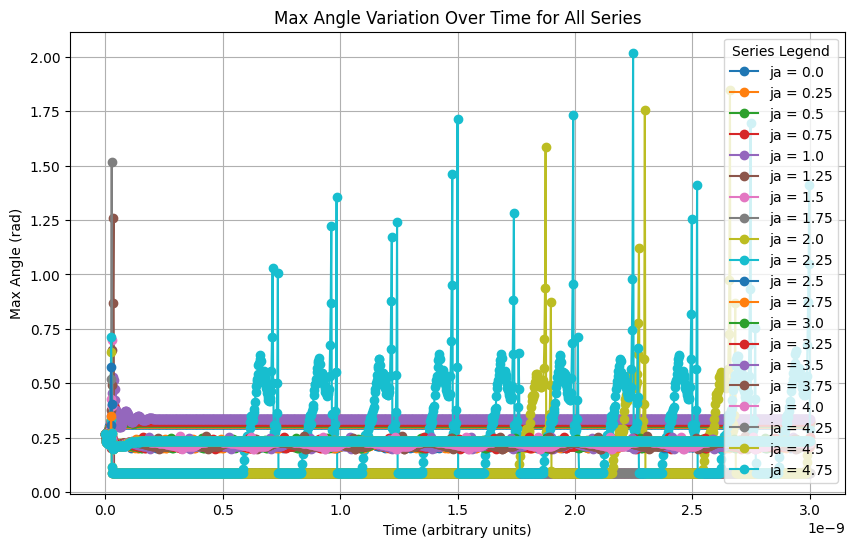

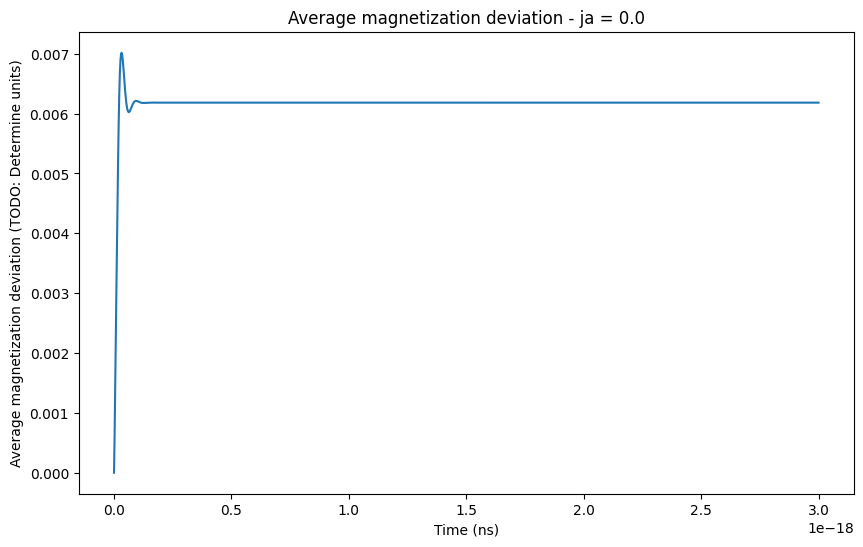

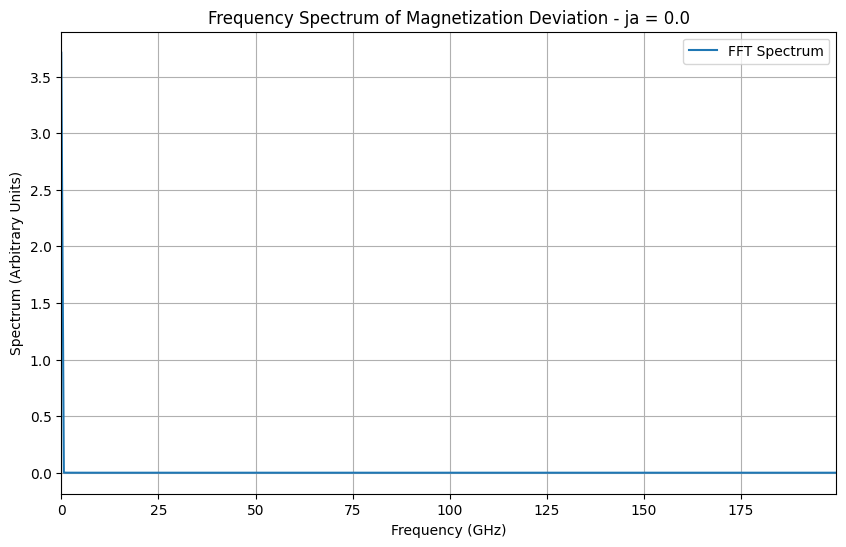

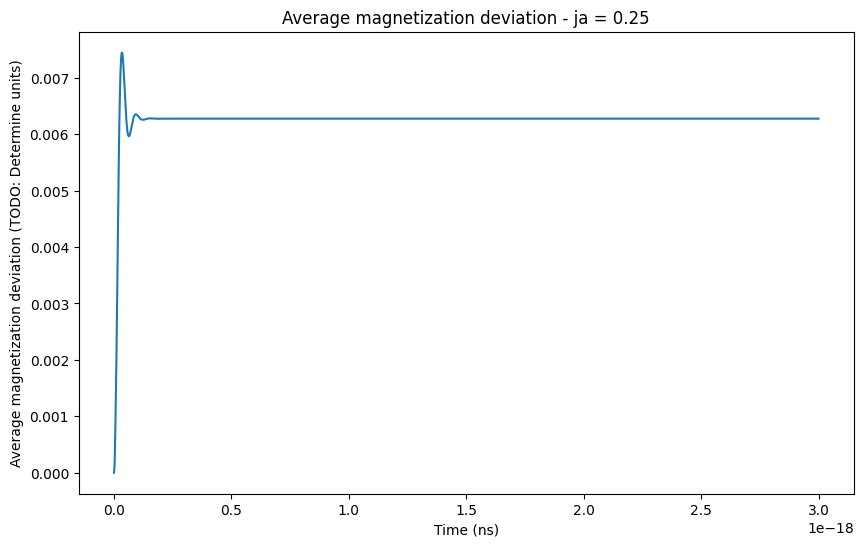

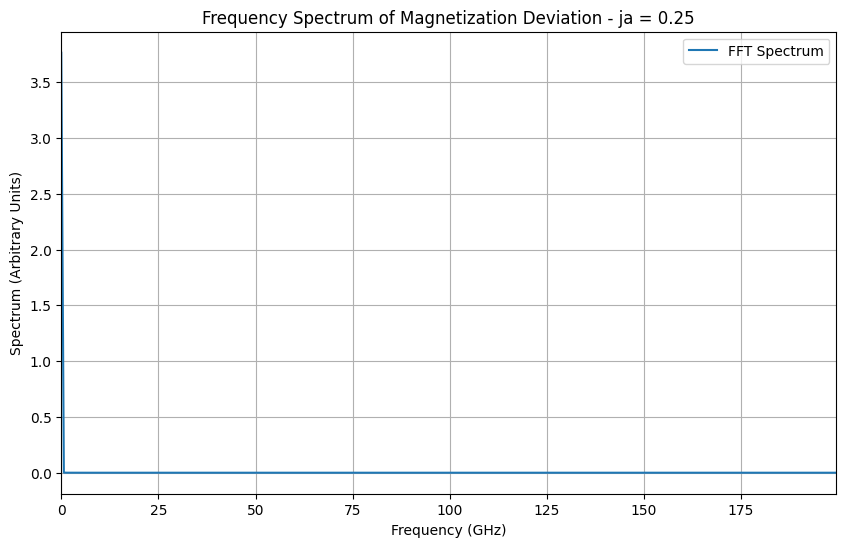

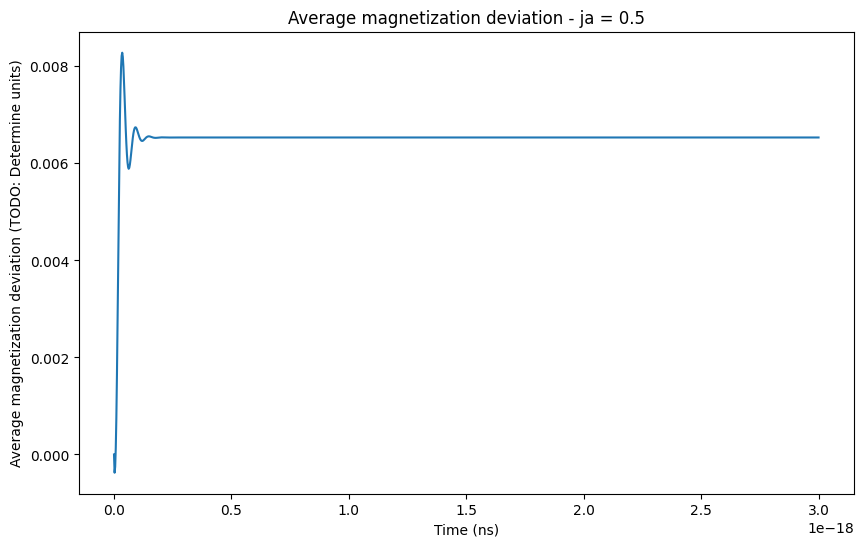

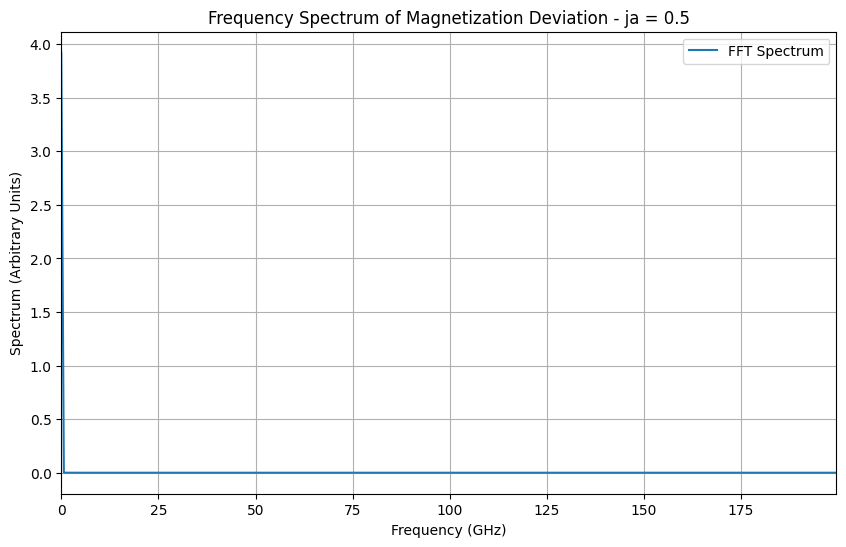

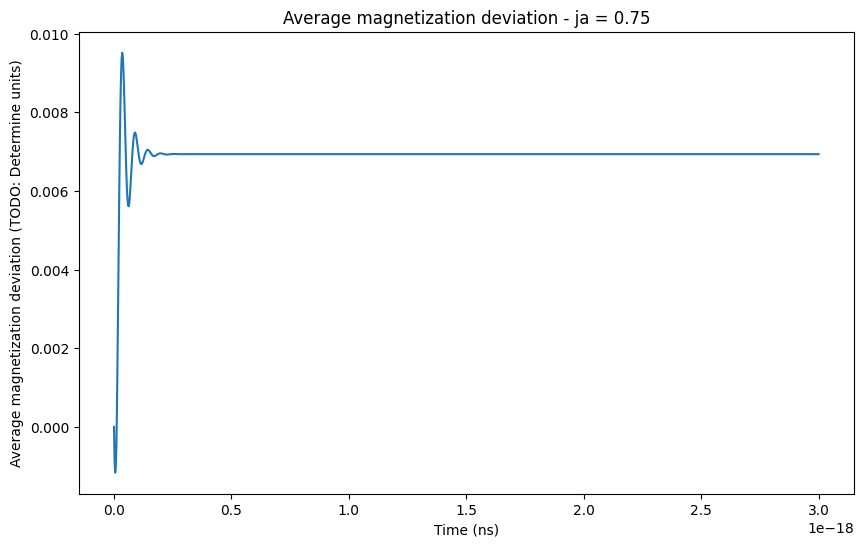

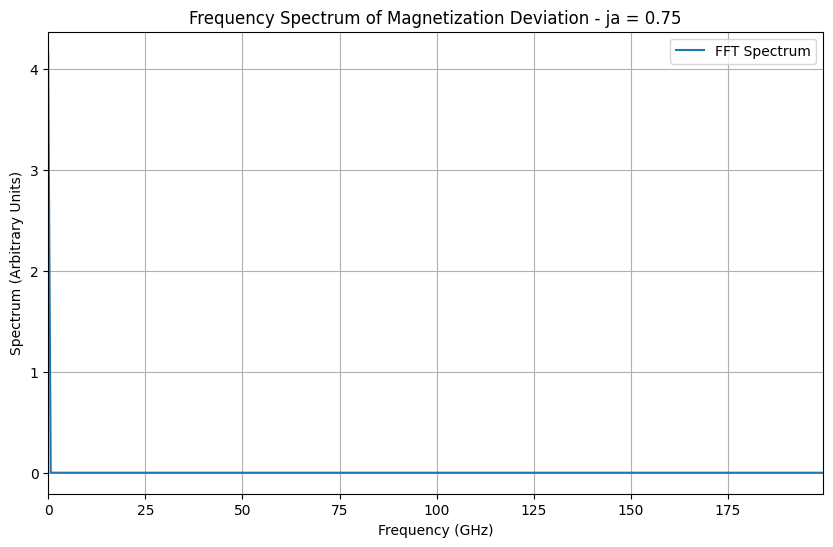

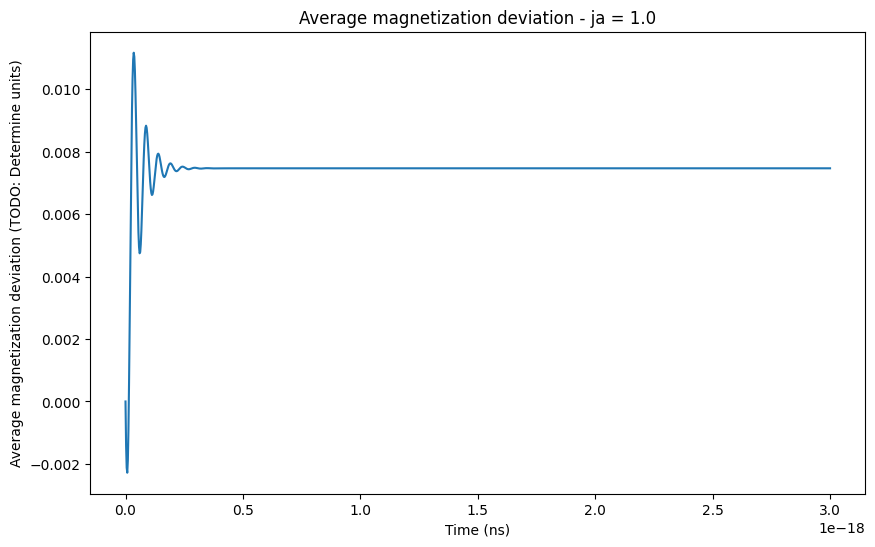

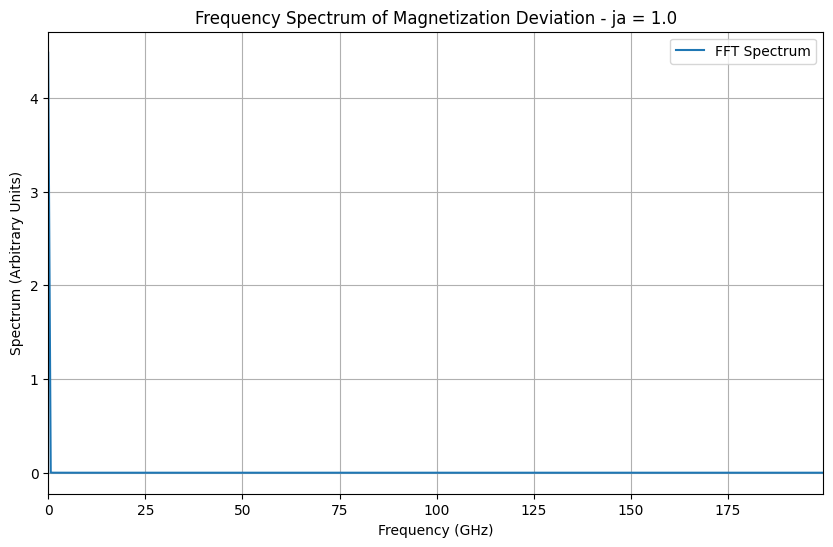

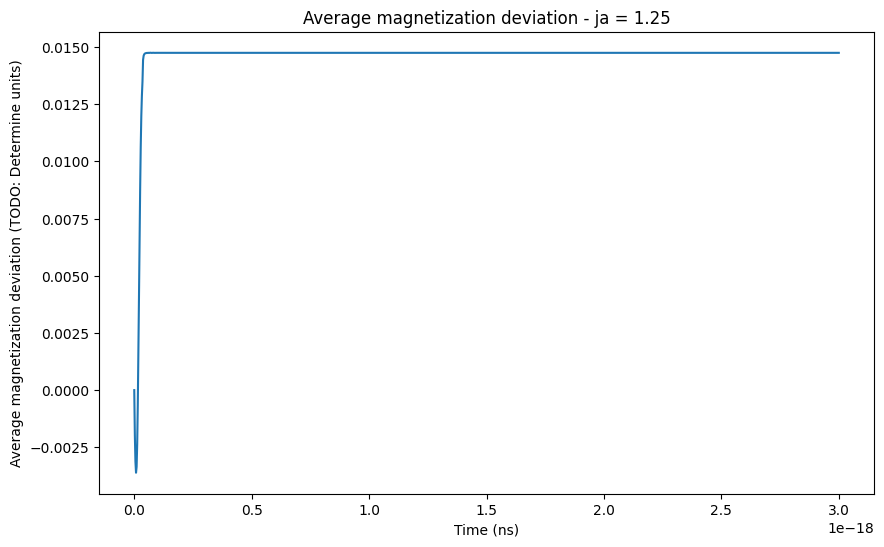

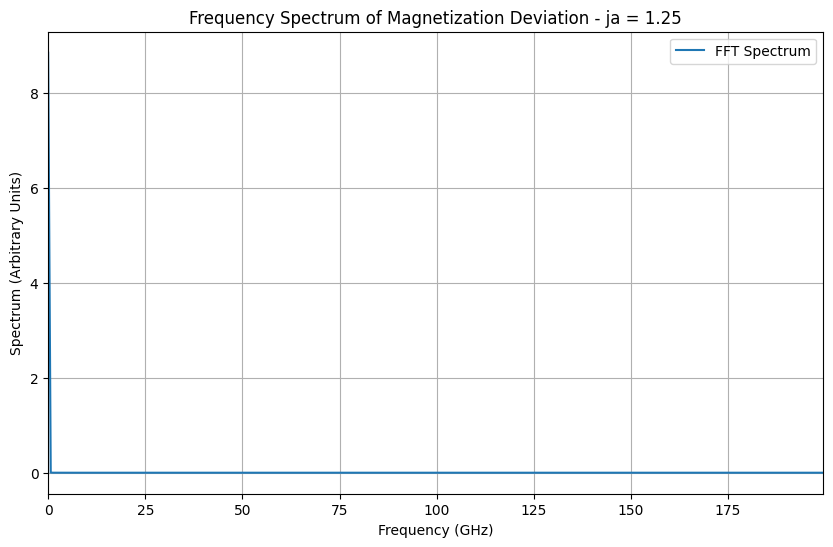

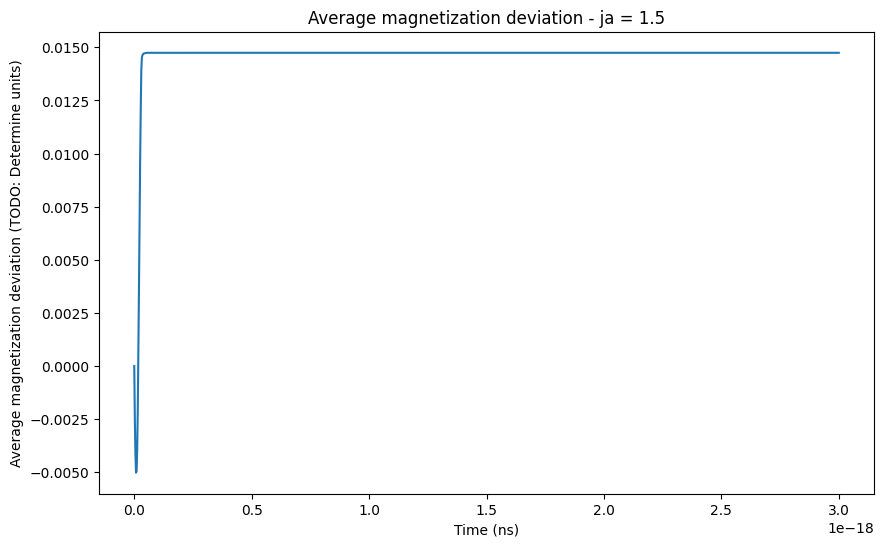

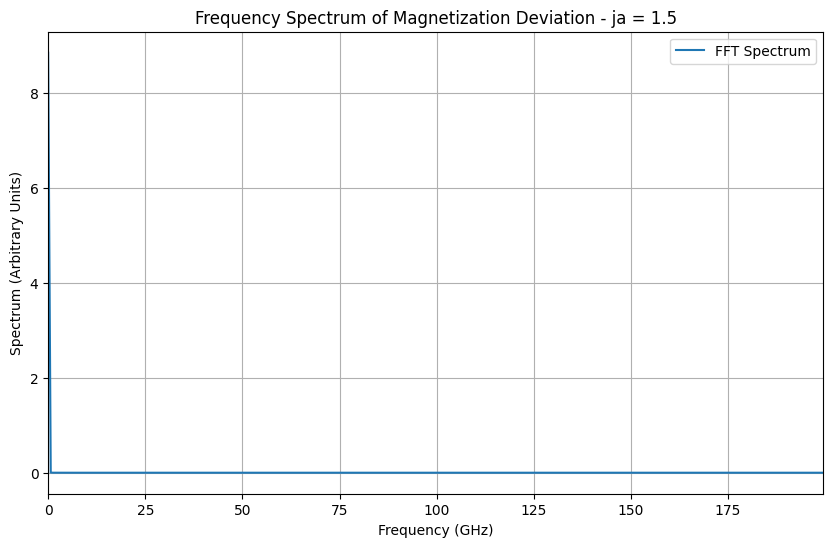

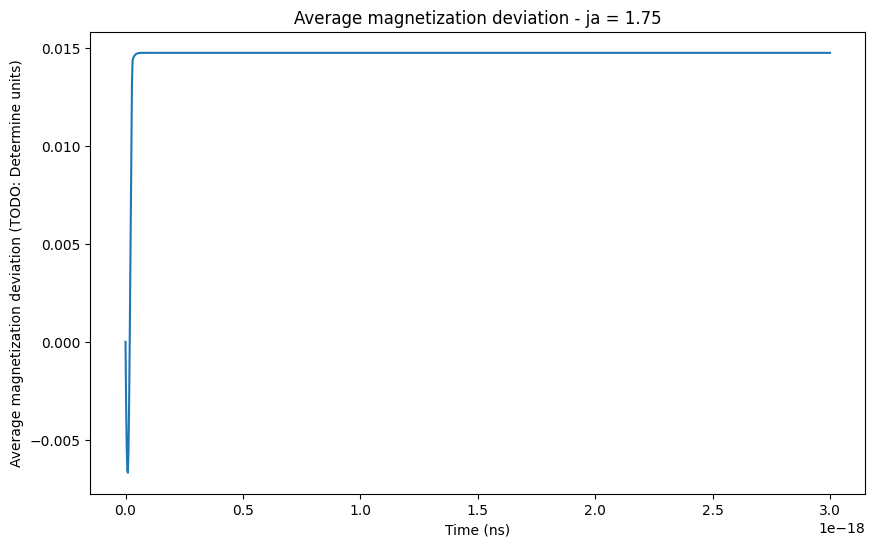

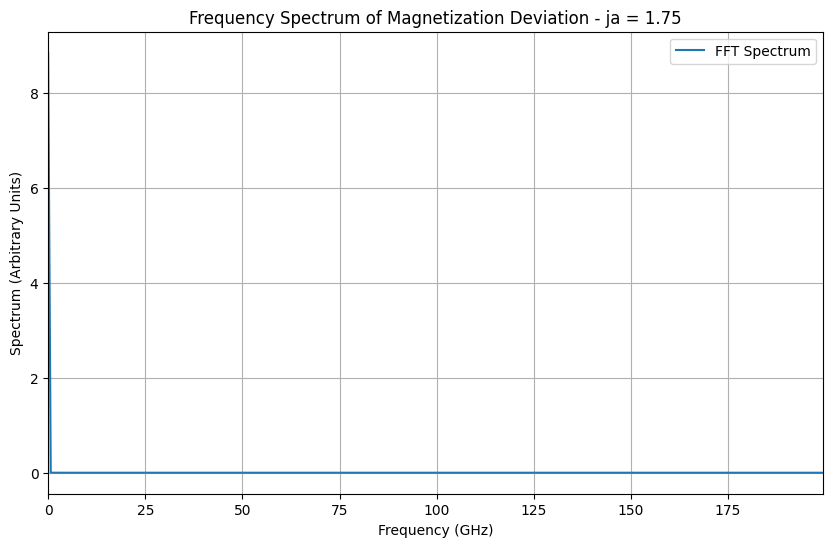

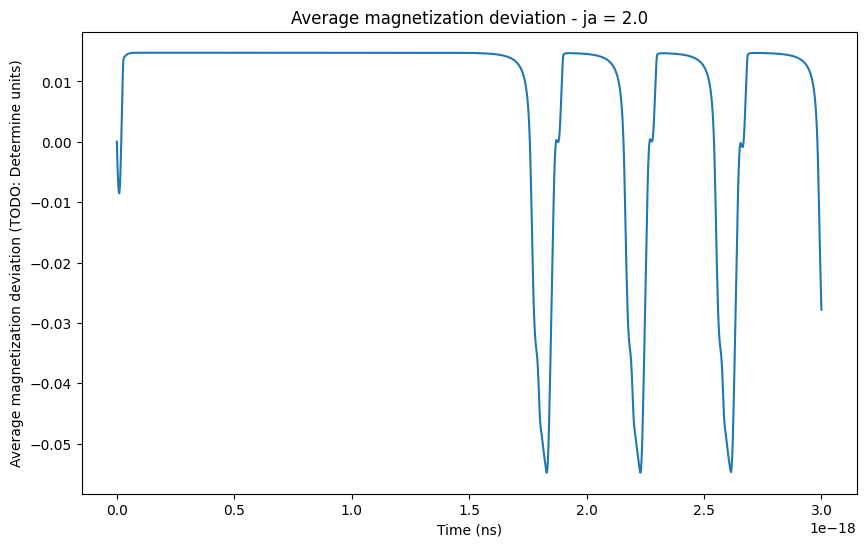

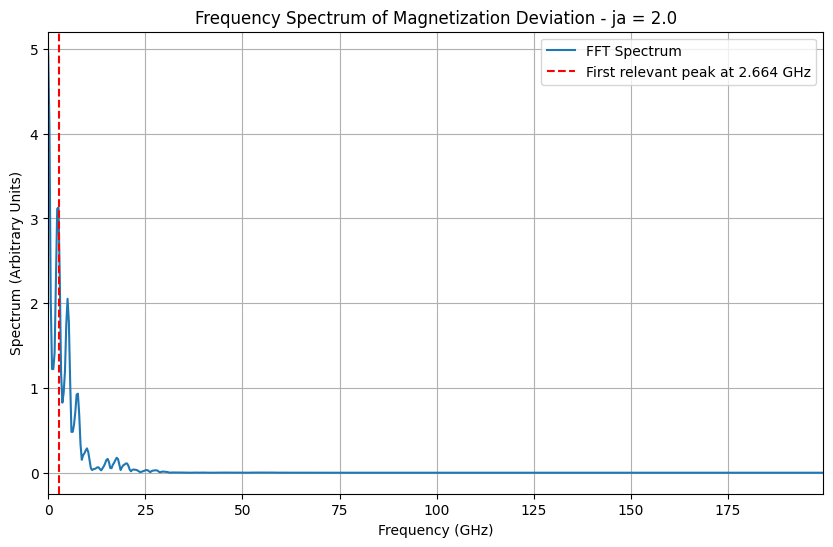

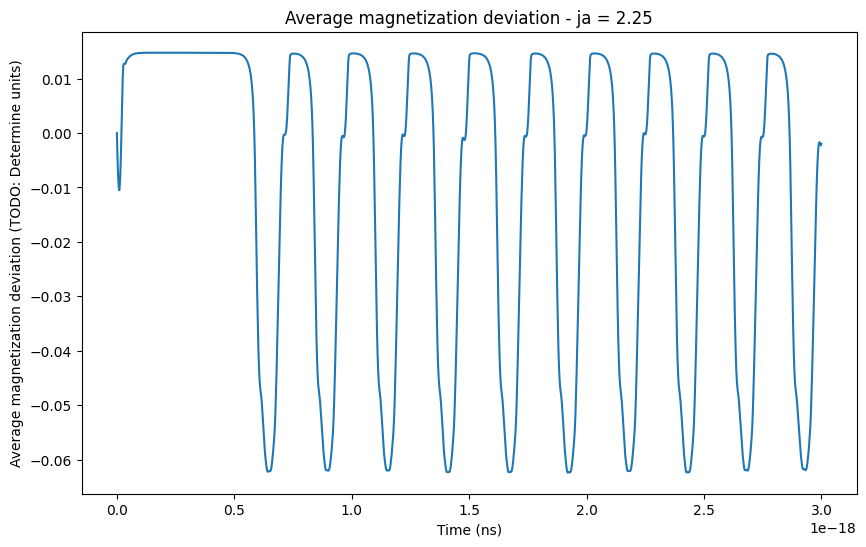

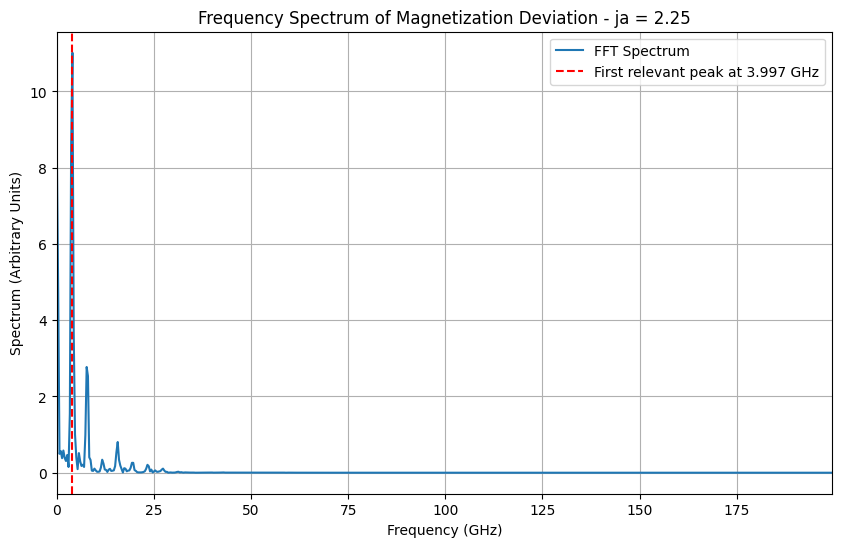

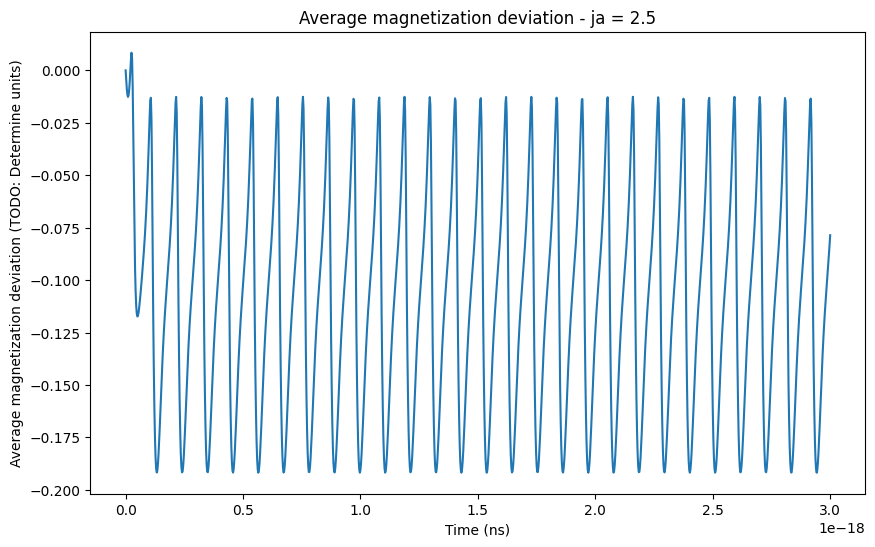

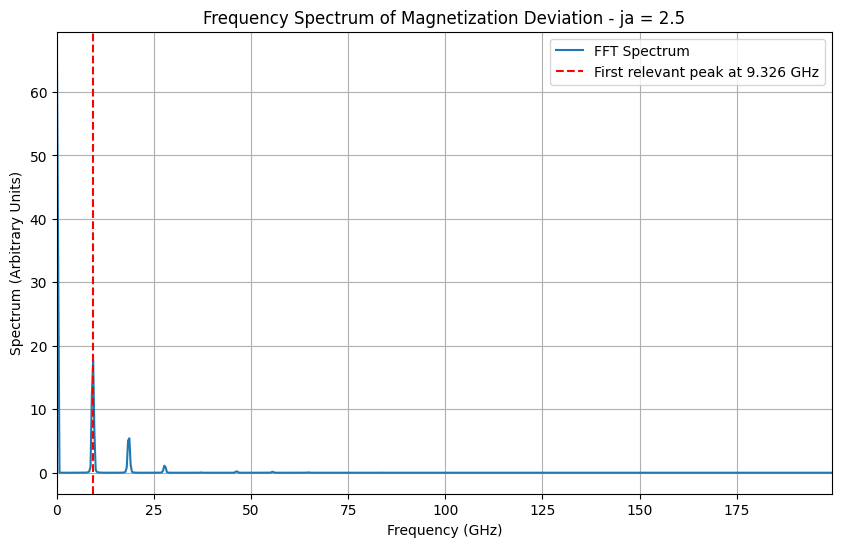

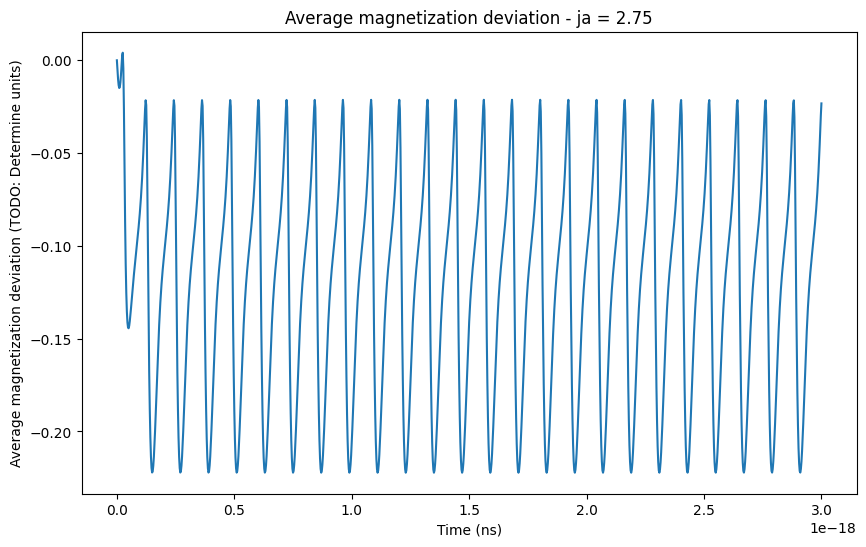

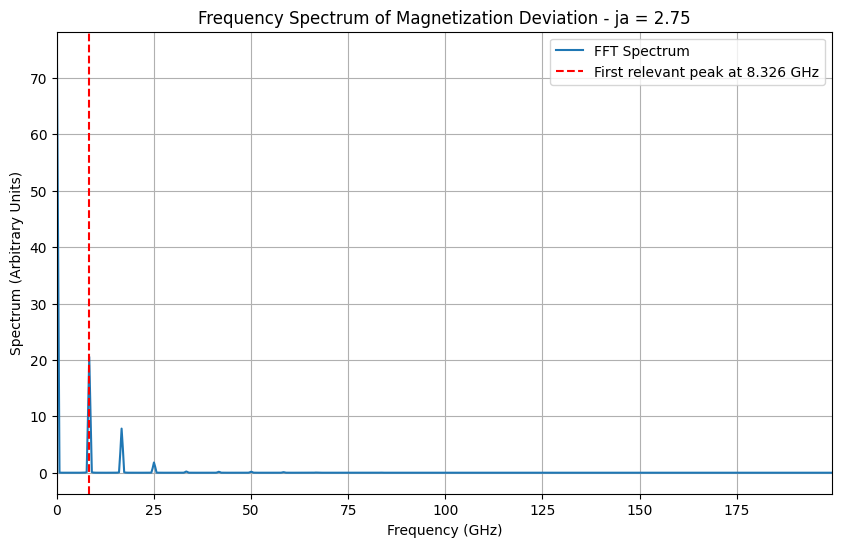

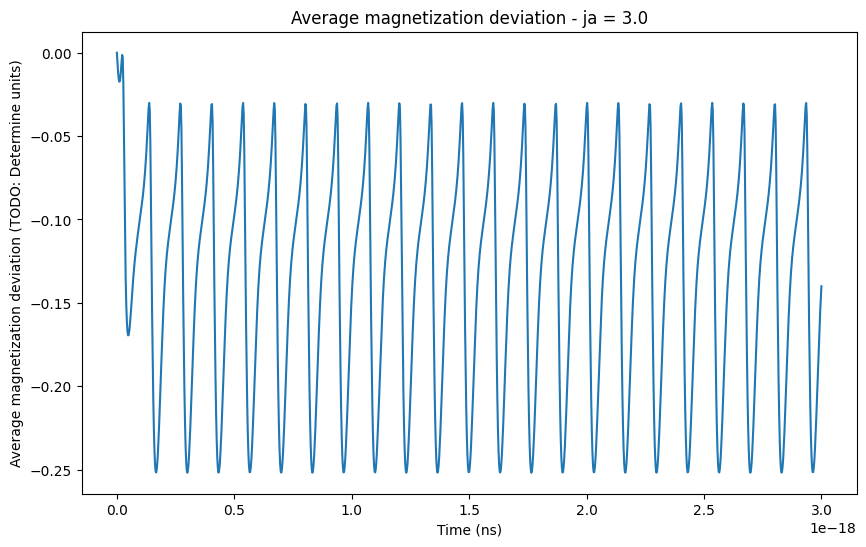

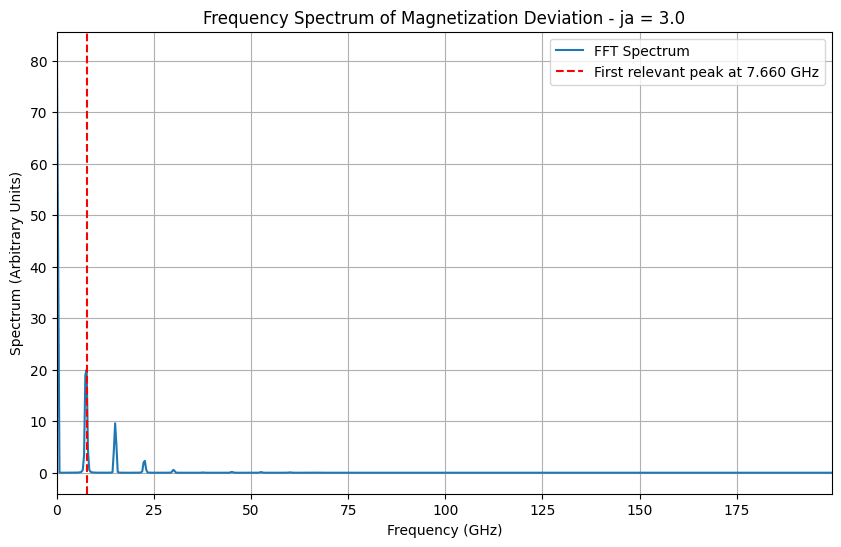

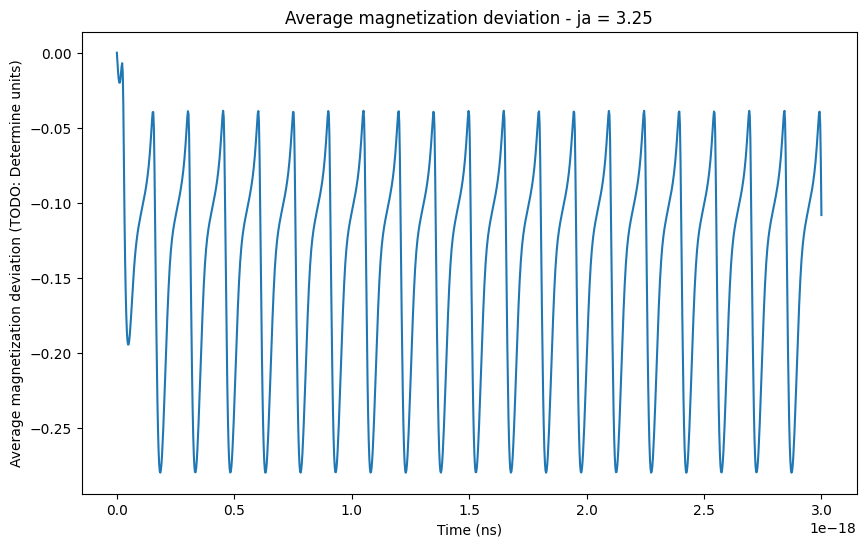

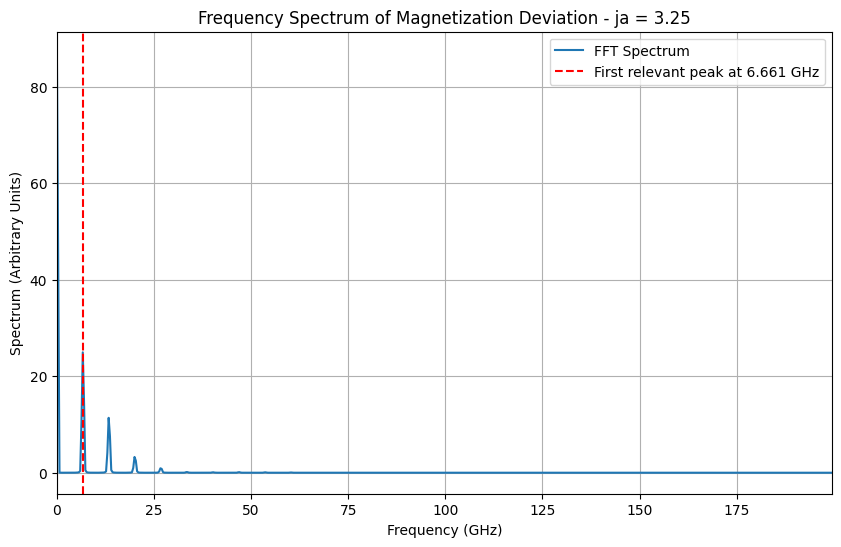

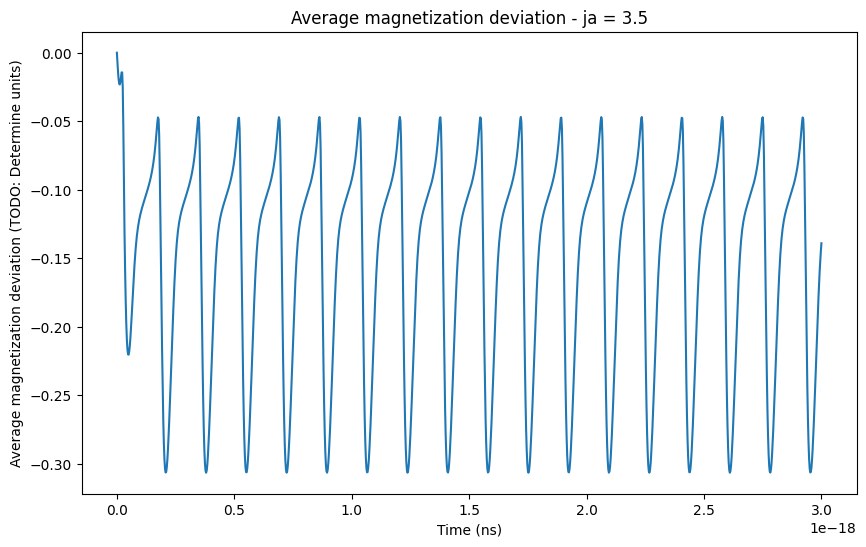

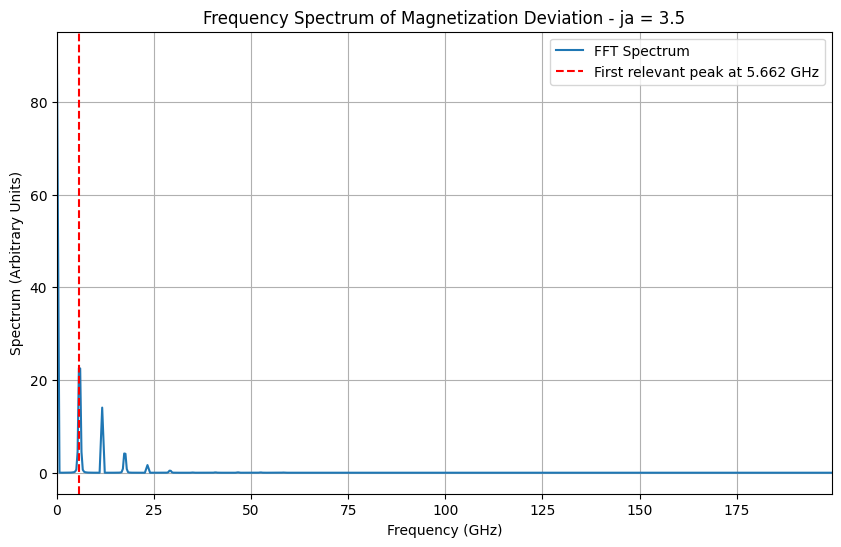

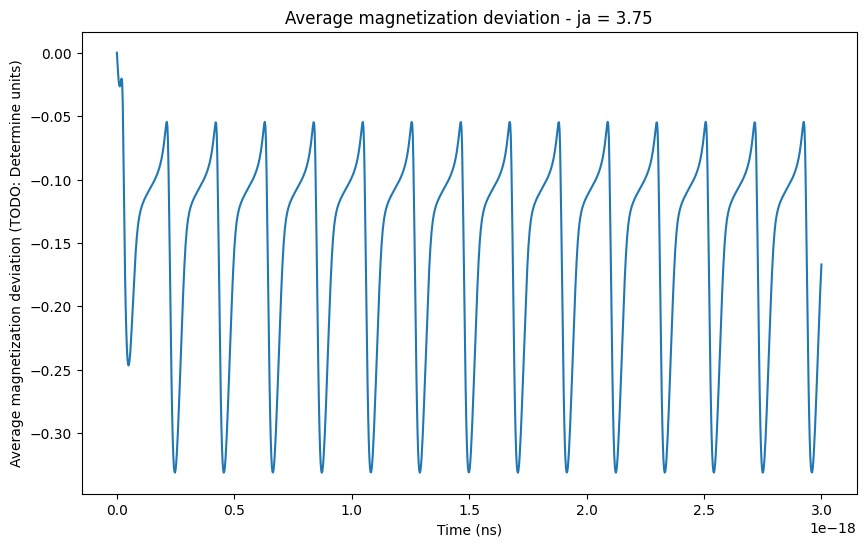

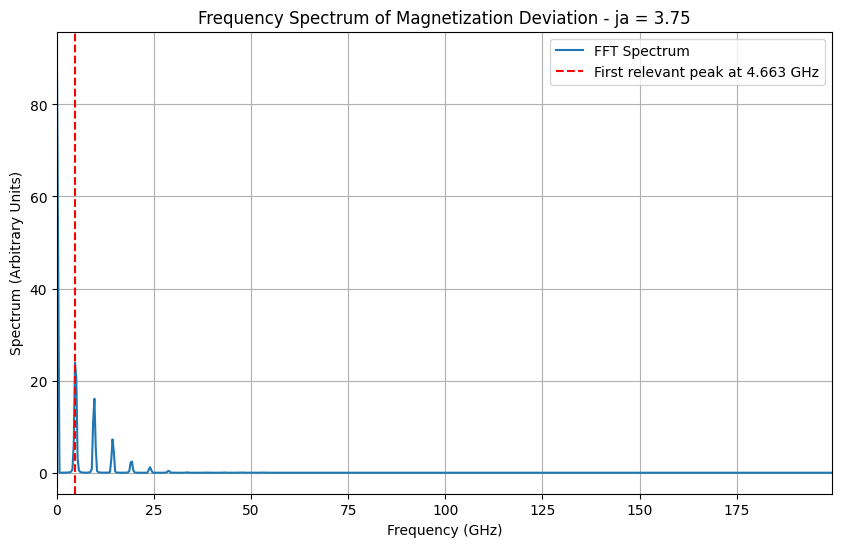

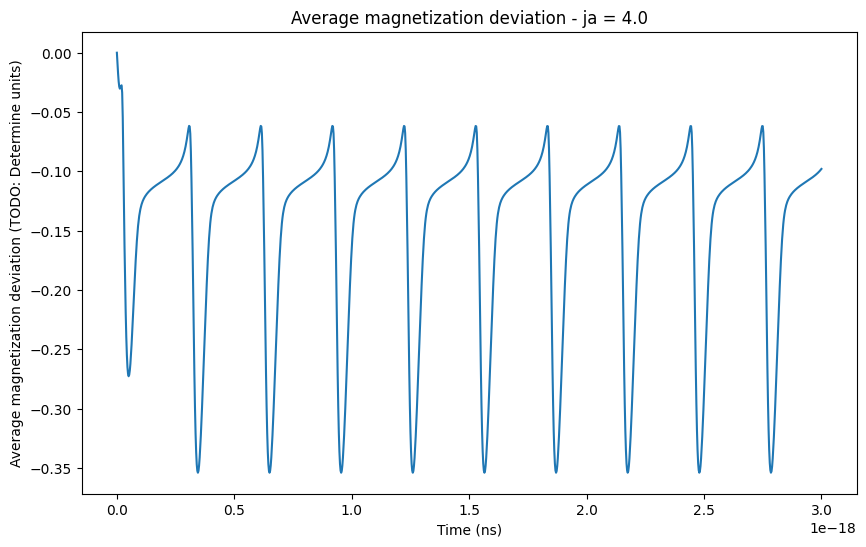

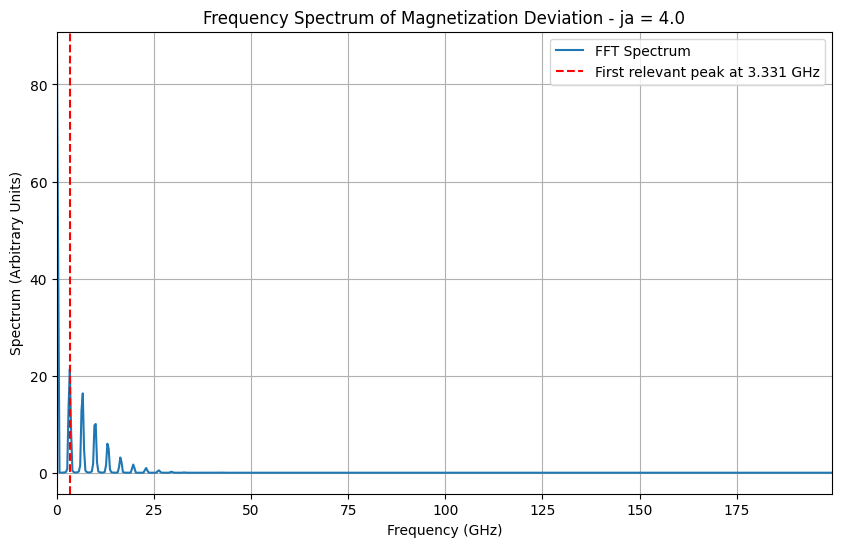

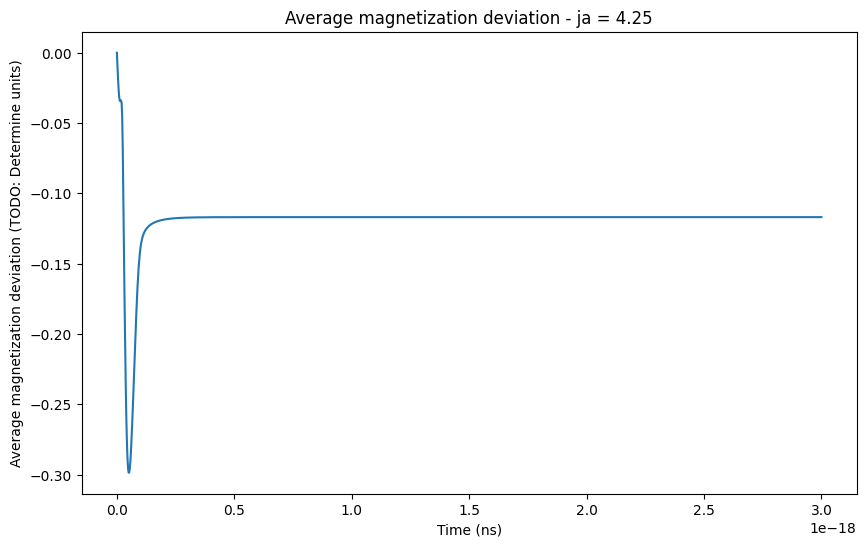

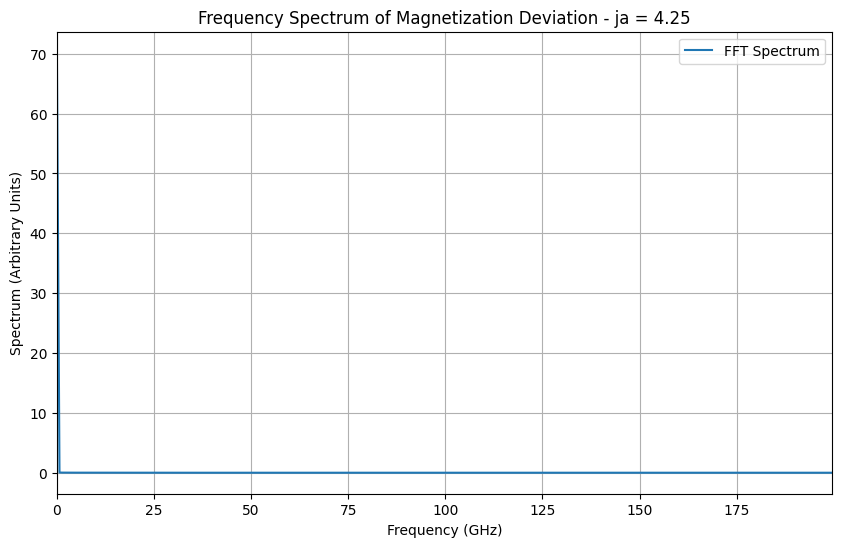

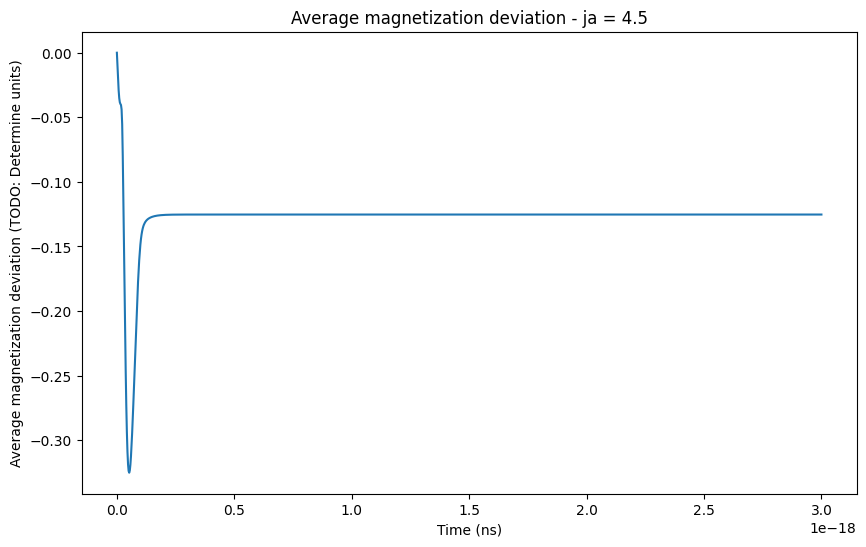

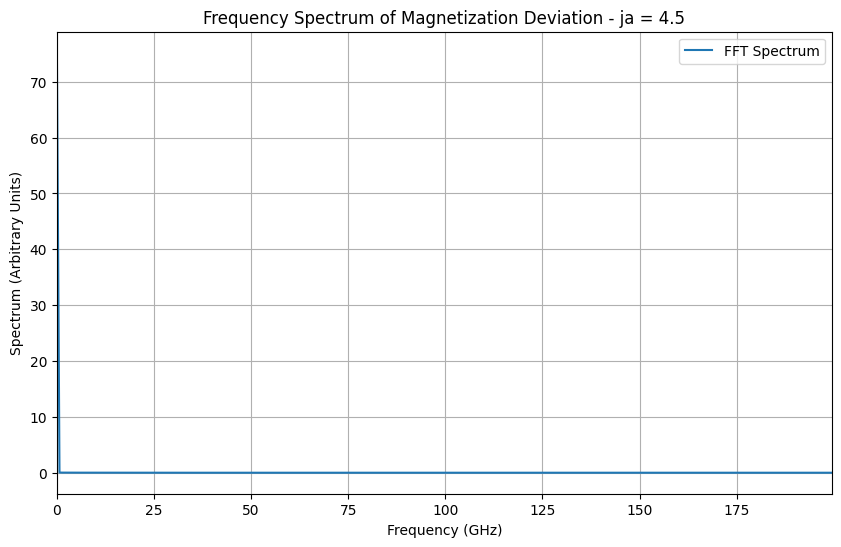

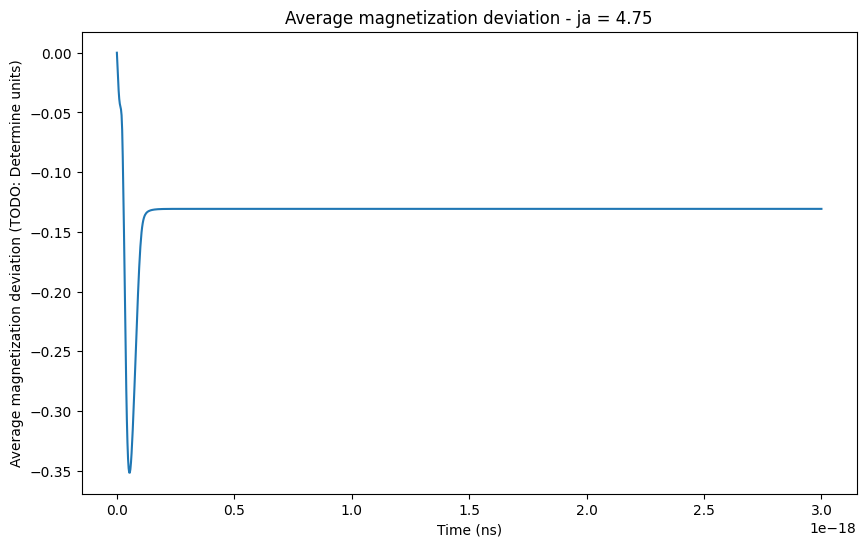

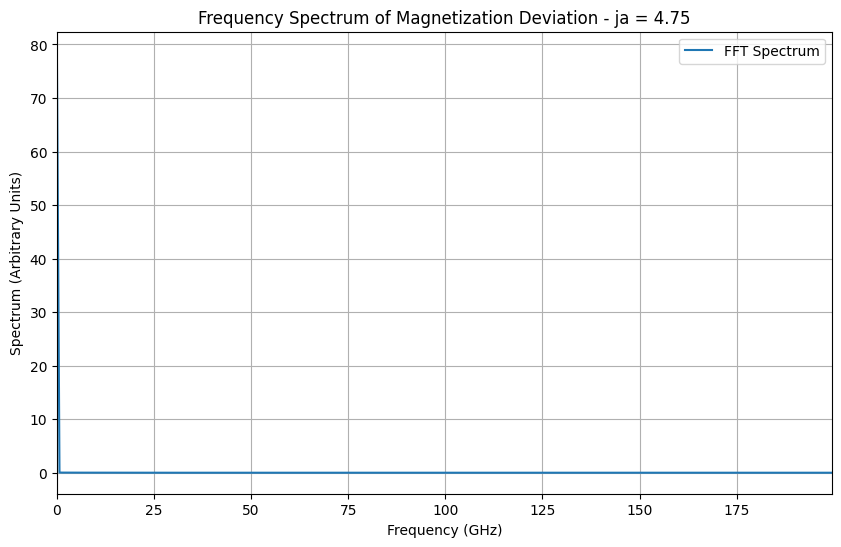

In [7]:
import matplotlib.pyplot as plt

iterated_lowest_frequencies = []

if 'ja_values' not in globals() or 'npy_dir' not in globals():
    iteration_dir = 'run_files'
    iteration_dir, iteration_number = get_latest_incremented_dir(iteration_dir)
    delete_path(os.path.join(iteration_dir, 'plots'))
    ja_values = extract_ja_values_by_folder_scheme(iteration_dir)
    npy_dir = os.path.join(iteration_dir, 'npy_arrays')
    default_fmax = 200e9
    default_dt = 1/(2*default_fmax)
    default_T = 2e-9
    default_Dind = 3e-3
    default_Ku1 = 0.8e+6
    default_sq_charge = 1

plot_output_dir = f'{iteration_dir}{os.path.sep}plots'
maxAngleFig, maxAngleAx = plt.subplots(figsize=(10, 6))  # Plot for maxAngles
 
# Read the table data from files and plot the results
for i in range(len(ja_values)):
    table_path = os.path.join(npy_dir, f'table_{i}.npy')
    table = np.load(table_path)
    table = pd.DataFrame(table, columns=["t", "mx", "my", "mz", "E_total", "maxangle"])
    dm = table["mz"] - table["mz"][0]  # average magnetization deviation
    t = table["t"]

    # Plot the Average magnetization deviation
    magFig, magAx = plt.subplots(figsize=(10, 6))  # Optional: Adjust figure size
    magAx.plot(t/1e9, dm, label='Average magnetization deviation')
    magAx.set_ylabel("Average magnetization deviation (TODO: Determine units)")
    magAx.set_xlabel("Time (ns)")
    magAx.set_title(f"Average magnetization deviation - ja = {ja_values[i]/1e12}")
    os.makedirs(plot_output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    mag_plot_filename = f"magFig_ja={ja_values[i]/1e12}.png"  # or .pdf, .svg, etc.
    mag_plot_path = os.path.join(plot_output_dir, mag_plot_filename)
    magFig.savefig(mag_plot_path)  # Save the plot to the file

    # Plot the fft spectrum
    fftFig, peak_freqs = identify_peaks_and_plot(dm, default_dt, default_fmax, ja_value=ja_values[i]/1e12, min_height=2)
    os.makedirs(plot_output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    fft_plot_filename = f"fftFig_ja={ja_values[i]/1e12}.png"  # or .pdf, .svg, etc.
    fft_plot_path = os.path.join(plot_output_dir, fft_plot_filename)
    fftFig.savefig(fft_plot_path)  # Save the plot to the file
    iterated_lowest_frequencies.append(peak_freqs)  # Save the lowest fft peak to an array for later plot

    # Plot the maxangle
    maxAngleAx.plot(table["t"], table["maxangle"], marker='o', linestyle='-', label=f'ja = {ja_values[i]/1e12}')
    maxAngleAx.set_xlabel('Time (arbitrary units)')
    maxAngleAx.set_ylabel('Max Angle (rad)')
    maxAngleAx.set_title('Max Angle Variation Over Time for All Series')
    maxAngleAx.legend(title='Series Legend')
    maxAngleAx.grid(True)

# Plot ja_values against iterated_lowest_frequencies

skyrmionOscillationVsCurrentFig, skyrmionOscillationVsCurrentAx = plt.subplots(figsize=(10, 6))  # Create the figure and axis
skyrmionOscillationVsCurrentAx.plot(ja_values/1e12, iterated_lowest_frequencies, marker='o')  # Plot with circle markers
skyrmionOscillationVsCurrentAx.set_xlabel('Ja (TA/m^2)')
skyrmionOscillationVsCurrentAx.set_ylabel('Oscillation frequency (GHz)')
skyrmionOscillationVsCurrentAx.set_title('Skyrmion oscillation frequency against spin current density')
skyrmionOscillationVsCurrentAx.grid(True)
skyrmionOscillationVsCurrentFig.savefig(os.path.join(plot_output_dir, "skyrmionOscillationVsCurrent.png"))  # Save the plot to the file

# Show the plot
maxAngleFig.savefig(os.path.join(plot_output_dir, "combined_maxangle_vs_time_colored.png"))

plt.close()